In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import folium

pd.set_option('display.max_columns', 60)
pd.set_option('display.max_rows', 60)
pd.set_option('mode.chained_assignment',  None)

plt.rc('font',family='malgun gothic')

smart_card_data = pd.read_csv('./data/smart_card_data.csv')
getrouteinfoall = pd.read_csv('./data/getRouteInfoAll.csv', encoding = 'cp949', index_col = 0)
getstationbyrouteall = pd.read_csv('./data/getStationByRouteAll.csv', encoding = 'cp949', index_col = 0)
bus_sttn = pd.read_csv('./data/bus_sttn.csv')
route_curve = pd.read_csv('./data/route_curve.csv', encoding = 'cp949')

display(smart_card_data.head(2))
display(getrouteinfoall.head(2))
display(getstationbyrouteall.head(2))
display(bus_sttn.head(2))
print(smart_card_data.shape, getrouteinfoall.shape, getstationbyrouteall.shape, bus_sttn.shape)

,SERIAL_NO,CARD_NO,GETON_YMD,GETON_TM,TRANSACTION_ID,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,BUS_CO_ID,BUS_CAR_ID,USR_TYPE,DRVN_START_YMD,DRVN_START_TM,GETON_BUS_STTN_ID,GETOFF_YMD,GETOFF_TM,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,DRVR_ID,GETON_CALC_YMD,GETOFF_CALC_YMD,ETL_TYPE,ETL_DATE
0,465526,541463722,20220401,81706,28,680,0,30300052,130010006,130752056,1,20220401,74957,8002432,20220401,083041,8001526,1,1250,0,,20220401,20220401,603,2022/04/12 07:02:59
1,465534,540104832,20220401,92542,17,675,0,30300083,130010001,130759426,1,20220401,61224,8001279,20220401,093729,8001538,1,1250,0,,20220401,20220401,603,2022/04/12 07:02:59


,ALLO_INTERVAL,ALLO_INTERVAL_SAT,ALLO_INTERVAL_SUN,BUSSTOP_CNT,END_NODE_ID,END_STOP_ID,ORIGIN_END,ORIGIN_END_SAT,ORIGIN_END_SUN,ORIGIN_START,ORIGIN_START_SAT,ORIGIN_START_SUN,ROUTE_CD,ROUTE_NO,ROUTE_TP,RUN_DIST_HALF,RUN_TM,START_NODE_ID,START_STOP_ID,TURN_END,TURN_END_SAT,TURN_END_SUN,TURN_NODE_ID,TURN_START,TURN_START_SAT,TURN_START_SUN,TURN_STOP_ID
0,30,30,30,106,8002737.0,42750.0,2230,2230,2230,600,600,630,30300001,1,5,23.6595,70,8002736,42740.0,2220,2220,2205,8007228,600,600,630,82370.0
1,8,9,10,62,9001783.0,44490.0,2230,2230,2230,545,545,545,30300002,2,1,28.7510,93,8001783,44490.0,2255,2255,2255,9002254,545,545,545,20980.0


,BUSSTOP_ENG_NM,BUSSTOP_NM,BUSSTOP_SEQ,BUSSTOP_TP,BUS_NODE_ID,BUS_STOP_ID,GPS_LATI,GPS_LONG,ROAD_NM,ROAD_NM_ADDR,ROUTE_CD,TOTAL_DIST
0,Chungnam National University,충대농대종점,1,1,8002736,42740,36.365704,127.352036,,,30300001,51
1,Hanbit Apts.,한빛아파트,2,,8002941,42720,36.362860,127.353004,,,30300001,434


,bus_sttn_id,bus_sttn_nm,posx,posy
0,8005005,분저리,36.437527,127.57069
1,8005009,삼양3리,36.308186,127.56326


(10261506, 25) (128, 27) (11631, 12) (3880, 4)


In [2]:
# data_preprocessing

### smart_card_data
smart_card_data = smart_card_data[smart_card_data['GETOFF_BUS_STTN_ID']!='~      '] # 하차 태그 없는 데이터 제거
smart_card_data['GETON_TM'] = smart_card_data['GETON_TM'].apply(lambda x: str(x).zfill(6)) # GETON_TM 컬럼 날짜형식으로 변환하기 위해 자릿수 맞춰주기

# datetime 형식으로 변환 및 새로운 column 생성
smart_card_data['GETON_DATETIME'] = pd.to_datetime(smart_card_data['GETON_YMD'].astype(str) + smart_card_data['GETON_TM'].astype(str), format = '%Y%m%d%H%M%S')
smart_card_data['GETOFF_DATETIME'] = pd.to_datetime(smart_card_data['GETOFF_YMD'].astype(str) + smart_card_data['GETOFF_TM'].astype(str), format = '%Y%m%d%H%M%S', errors = 'coerce')
smart_card_data['WEEKDAY'] = smart_card_data['GETON_DATETIME'].dt.weekday
smart_card_data['DAY'] = smart_card_data['GETON_DATETIME'].dt.day

# 평일만 추출
weekday_values = [0, 1, 2, 3, 4]
smart_card_data = smart_card_data[smart_card_data['WEEKDAY'].isin(weekday_values)]

# 여러명이 탄 경우 제거
smart_card_data = smart_card_data[smart_card_data['YSR_CNT']==1]

# 사용한 행 제거
smart_card_data.drop(labels = ['GETON_YMD','GETON_TM','GETOFF_YMD','GETOFF_TM'], axis = 1, inplace = True)

# 필요없는 행 제거
smart_card_data.drop(labels = ['SERIAL_NO', 'TRANSACTION_ID', 'BUS_CO_ID', 'BUS_CAR_ID', 'DRVR_ID','DRVN_START_YMD','DRVN_START_TM','GETON_CALC_YMD', 'GETOFF_CALC_YMD', 'ETL_TYPE', 'ETL_DATE'], axis = 1, inplace = True)

### getrouteinfoall
getrouteinfoall_df = getrouteinfoall[['ROUTE_CD','ROUTE_NO']] 

### bus_sttn
bus_sttn_df = bus_sttn[['bus_sttn_id', 'posx', 'posy']]

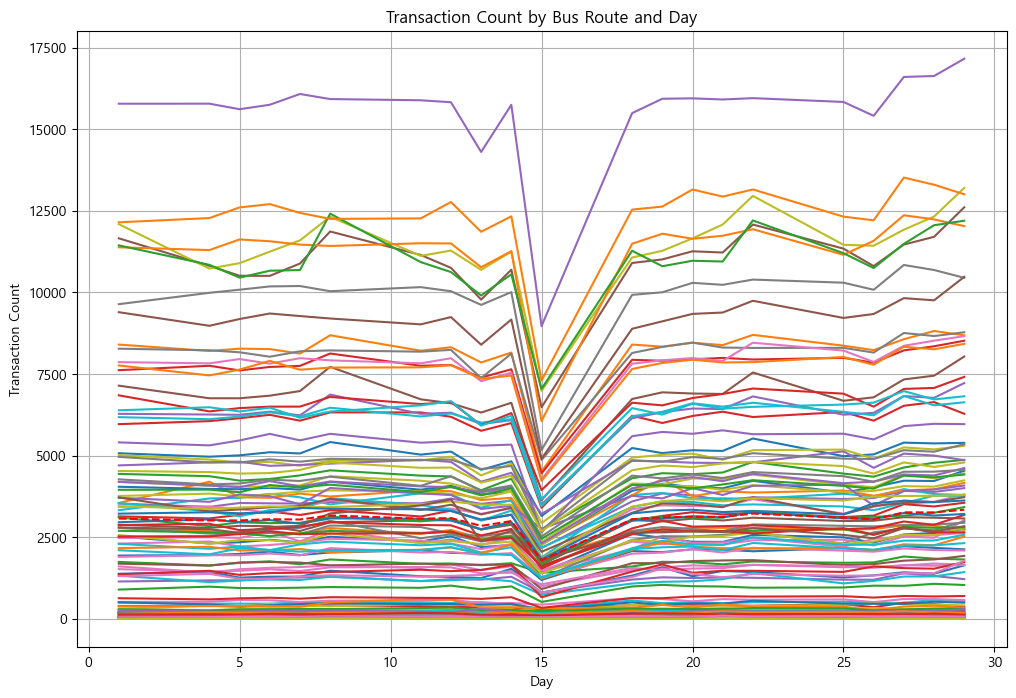

In [3]:
# BUS_ROUTE_ID와 DAY를 기준으로 데이터를 그룹화하고 각 그룹의 행 수를 계산
grouped_data = smart_card_data.groupby(['BUS_ROUTE_ID', 'DAY']).size().reset_index(name='COUNT')

# 각 날짜별로 모든 버스 노선에 대한 평균 거래 수를 계산
daily_average = grouped_data.groupby('DAY')['COUNT'].mean().reset_index(name='DAILY_AVERAGE')

# 각 날짜별로 평균 거래 수에 가장 가까운 거래 수를 가진 날짜를 찾음
closest_dates = []
for _, row in daily_average.iterrows():
    day = row['DAY']
    average_count = row['DAILY_AVERAGE']
    closest_date = grouped_data.loc[grouped_data['DAY'] == day, 'COUNT'].\
                   apply(lambda x: abs(x - average_count)).idxmin()
    closest_dates.append(grouped_data.loc[closest_date, 'BUS_ROUTE_ID'])

# 각 버스 노선별로 그래프를 그리는 함수를 생성
def plot_route_graph(route_id):
    route_data = grouped_data[grouped_data['BUS_ROUTE_ID'] == route_id]
    plt.plot(route_data['DAY'], route_data['COUNT'], label=f'Route {route_id}')

# 유일한 BUS_ROUTE_ID 값을 가져옴
unique_route_ids = smart_card_data['BUS_ROUTE_ID'].unique()

plt.figure(figsize=(12, 8))
for route_id in unique_route_ids:
    plot_route_graph(route_id)

# 각 날짜별로 모든 버스 노선에 대한 평균 거래 수를 나타내는 선을 추가
plt.plot(daily_average['DAY'], daily_average['DAILY_AVERAGE'], color='r', linestyle='--', label='Daily Average')

plt.xlabel('Day')
plt.ylabel('Transaction Count')
plt.title('Transaction Count by Bus Route and Day')
plt.grid(True)
plt.show()

In [4]:
daily_average = daily_average[daily_average['DAY']!=15] # 15일의 DAILY_AVERAGE는 이상치라 판단하여 제거해줌
daily_average['AVERAGE'] = daily_average['DAILY_AVERAGE'].mean() # 일별 평균의 평균을 구해줌
daily_average['DIFFERENCE'] = abs(daily_average['DAILY_AVERAGE'] - daily_average['AVERAGE']) # 일별 평균의 평균과 일별 평균의 차이를 구함
daily_average.sort_values('DIFFERENCE',ascending = True).head(5) # 차이가 가장 적은 날짜 : 4월 25일

,DAY,DAILY_AVERAGE,AVERAGE,DIFFERENCE
16,25,3098.238532,3100.855505,2.616972
12,19,3109.183486,3100.855505,8.327982
7,12,3087.541284,3100.855505,13.314220
14,21,3120.908257,3100.855505,20.052752
13,20,3128.559633,3100.855505,27.704128


# 4월 25일 데이터

In [5]:
df_0425 = smart_card_data[smart_card_data['DAY']==25]
df_0425.drop(labels = ['WEEKDAY','DAY'],axis = 1, inplace = True)
df_0425['GETON_HOUR'] = df_0425['GETON_DATETIME'].dt.hour
df_0425.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
169539,734471053,675,0,30300059,1,8006006,8001930,1,1250,0,2022-04-25 19:19:47,2022-04-25 19:38:02,19
169540,661607970,676,0,30300070,1,8002794,8002155,1,1250,0,2022-04-25 07:53:58,2022-04-25 08:16:20,7
169541,706749254,675,0,30300079,1,8001721,8002802,1,1250,0,2022-04-25 08:07:51,2022-04-25 08:39:44,8


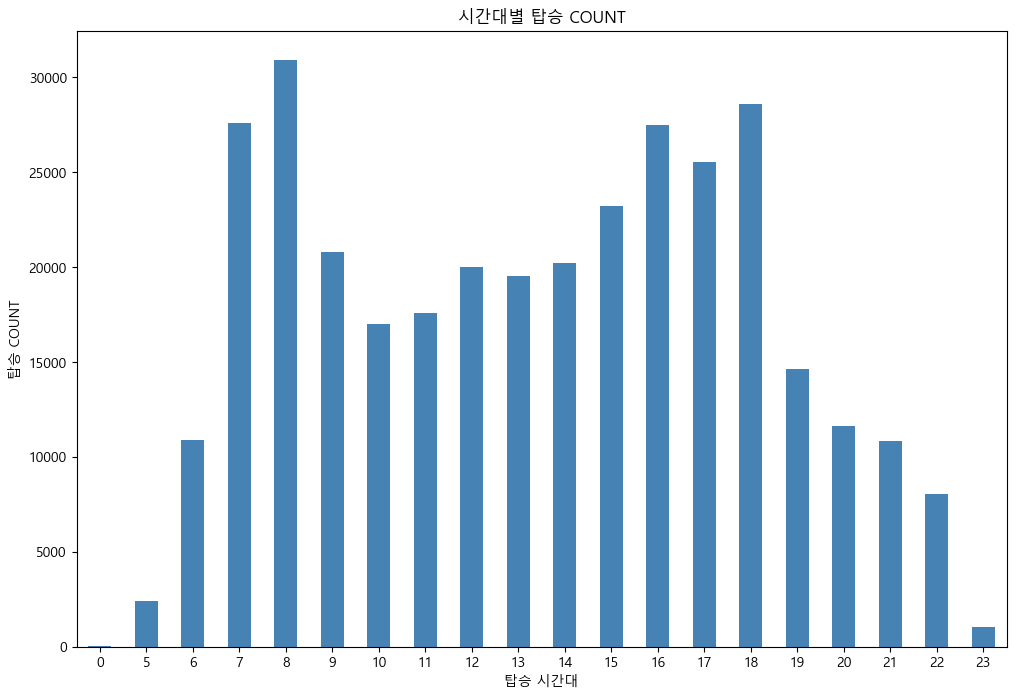

In [6]:
# GETON_HOUR을 기준으로 그룹화하여 해당 시간대별 이용자 수를 계산
hourly_usage = df_0425.groupby('GETON_HOUR')['CARD_NO'].count()

plt.figure(figsize=(12, 8))
hourly_usage.plot(kind='bar',  color = 'steelblue')
plt.xlabel('탑승 시간대')
plt.ylabel('탑승 COUNT')
plt.xticks(rotation=0)
plt.title('시간대별 탑승 COUNT')
plt.show()

## 출근 시간대 (7시, 8시, 9시)

In [7]:
# 출근시간대만 추출
go_to_values = [7,8,9]
df_0425_go_to = df_0425[df_0425['GETON_HOUR'].isin(go_to_values)]

In [8]:
df_0425_go_to.shape

(79278, 13)

In [9]:
# TRANSF_CNT가 3인 CARD_NO를 가져옴
card_nos_to_remove = df_0425_go_to[df_0425_go_to['TRANSF_CNT'] == 3]['CARD_NO']
# 지정된 CARD_NO에 해당하는 행을 제거
df_0425_go_to = df_0425_go_to[~df_0425_go_to['CARD_NO'].isin(card_nos_to_remove)]

### 환승횟수 3인 경우 대부분 타지역에서 오는 경우 ###

### 환승횟수 2회

In [17]:
dataframes_by_card_no = {}

# TRANSF_CNT가 2인 경우의 CARD_NO 값들을 가져옴
unique_card_nos = set(df_0425_go_to[df_0425_go_to['TRANSF_CNT'] == 2]['CARD_NO'].unique())

# 고유한 CARD_NO 값들을 순회하며 데이터프레임 생성
for idx, card_no in enumerate(unique_card_nos, 1):
    # 현재 CARD_NO에 해당하는 데이터를 원본 데이터프레임에서 필터링하고, GETON_DATETIME으로 정렬
    filtered_df = df_0425_go_to[df_0425_go_to['CARD_NO'] == card_no].sort_values('GETON_DATETIME')
    
    # 현재 필터링된 데이터프레임을 딕셔너리에 저장
    dataframes_by_card_no[idx] = filtered_df

# 딕셔너리의 모든 데이터프레임을 합쳐서 하나의 데이터프레임으로 만듦
combined_dataframe = pd.concat(dataframes_by_card_no.values(), ignore_index=True) # (3818, 13)

In [18]:
combined_dataframe = combined_dataframe.sort_values(by = ['CARD_NO','GETON_DATETIME'])
combined_dataframe.shape

(3818, 13)

In [19]:
# 환승횟수가 2인 경우 unique한 CARD_NO 당 최소 3개(0,1,2)가 존재해야하므로
transf_is_2_morning = combined_dataframe[combined_dataframe['CARD_NO'].map(combined_dataframe['CARD_NO'].value_counts()) == 3]
transf_not_2_morning = combined_dataframe[combined_dataframe['CARD_NO'].map(combined_dataframe['CARD_NO'].value_counts()) != 3]
print(transf_is_2_morning.shape, transf_not_2_morning.shape)
print(len(transf_is_2_morning['CARD_NO'].unique())) # 환승횟수가 2회이면서 모든 값이 존재하는 unique한 CARD_NO의 개수 : 713, 즉, 4월 25일 환승을 2번한 713명 승객에 대한 데이터

(2139, 13) (1679, 13)
713


In [20]:
transf_is_2_ex = transf_is_2_morning.iloc[:3,:]
transf_is_2_ex

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
82,91472025,676,0,30300043,1,8001358,8001628,1,1250,0,2022-04-25 08:18:09,2022-04-25 09:04:33,8
83,91472025,675,1,30300095,1,8002935,8001250,1,0,0,2022-04-25 09:47:15,2022-04-25 09:52:46,9
84,91472025,675,2,30300067,1,8001250,8002635,1,0,0,2022-04-25 09:53:23,2022-04-25 10:11:20,9


In [21]:
### 하나의 데이터만 샘플로 적용하는 코드 ###
# exdata = pd.DataFrame({'CARD_NO' : transf_is_2_ex['CARD_NO'].unique(),
#                        'TR_MEANS_TYPE_1' : transf_is_2_ex['TR_MEANS_TYPE'].values[0],
#                        'TRANSF_CNT' : transf_is_2_ex['TRANSF_CNT'].values[0],
#                        'BUS_ROUTE_ID_1' : transf_is_2_ex['BUS_ROUTE_ID'].values[0],
#                        'GETON_BUS_STTN_ID_1' : transf_is_2_ex['GETON_BUS_STTN_ID'].values[0],
#                        'GETON_PAY_1' : transf_is_2_ex['GETON_PAY'].values[0],
#                        'GETON_DATETIME_1' : transf_is_2_ex['GETON_DATETIME'].values[0],
#                        'GETOFF_BUS_STTN_ID_1' : transf_is_2_ex['GETOFF_BUS_STTN_ID'].values[0],
#                        'GETOFF_PAY_1' : transf_is_2_ex['GETOFF_PAY'].values[0],
#                        'GETOFF_DATETIME_1': transf_is_2_ex['GETOFF_DATETIME'].values[0],
#                        'TR_MEANS_TYPE_2' : transf_is_2_ex['TR_MEANS_TYPE'].values[1],
#                        'BUS_ROUTE_ID_2' : transf_is_2_ex['BUS_ROUTE_ID'].values[1],
#                        'GETON_BUS_STTN_ID_2' : transf_is_2_ex['GETON_BUS_STTN_ID'].values[1],
#                        'GETON_PAY_2' : transf_is_2_ex['GETON_PAY'].values[1],
#                        'GETON_DATETIME_2' : transf_is_2_ex['GETON_DATETIME'].values[1],
#                        'GETOFF_BUS_STTN_ID_2' : transf_is_2_ex['GETOFF_BUS_STTN_ID'].values[1],
#                        'GETOFF_PAY_2' : transf_is_2_ex['GETOFF_PAY'].values[1],
#                        'GETOFF_DATETIME_2': transf_is_2_ex['GETOFF_DATETIME'].values[1],
#                        'TR_MEANS_TYPE_3' : transf_is_2_ex['TR_MEANS_TYPE'].values[2],
#                        'BUS_ROUTE_ID_3' : transf_is_2_ex['BUS_ROUTE_ID'].values[2],
#                        'GETON_BUS_STTN_ID_3' : transf_is_2_ex['GETON_BUS_STTN_ID'].values[2],
#                        'GETON_PAY_3' : transf_is_2_ex['GETON_PAY'].values[2],
#                        'GETON_DATETIME_3' : transf_is_2_ex['GETON_DATETIME'].values[2],
#                        'GETOFF_BUS_STTN_ID_3' : transf_is_2_ex['GETOFF_BUS_STTN_ID'].values[2],
#                        'GETOFF_PAY_3' : transf_is_2_ex['GETOFF_PAY'].values[2],
#                        'GETOFF_DATETIME_3': transf_is_2_ex['GETOFF_DATETIME'].values[2],
#                        })
# exdata

In [22]:
rows = []

unique_card_nos = transf_is_2_morning['CARD_NO'].unique() # 'CARD_NO' 열에서 유니크한 카드 번호를 추출
for card_no in unique_card_nos: # 각 카드 번호별로 반복
    card_data = transf_is_2_morning[transf_is_2_morning['CARD_NO'] == card_no] # 현재 카드 번호에 해당하는 데이터를 추출

    # 각 CARD_NO에 대해 두 개의 분리된 행을 생성
    row_data = {
        'CARD_NO': card_no,
        'TR_MEANS_TYPE_1': card_data['TR_MEANS_TYPE'].values[0],
        'TRANSF_CNT': card_data['TRANSF_CNT'].values[0],
        'BUS_ROUTE_ID_1': card_data['BUS_ROUTE_ID'].values[0],
        'GETON_BUS_STTN_ID_1': card_data['GETON_BUS_STTN_ID'].values[0],
        'GETON_PAY_1': card_data['GETON_PAY'].values[0],
        'GETON_DATETIME_1': card_data['GETON_DATETIME'].values[0],
        'GETOFF_BUS_STTN_ID_1': card_data['GETOFF_BUS_STTN_ID'].values[0],
        'GETOFF_PAY_1': card_data['GETOFF_PAY'].values[0],
        'GETOFF_DATETIME_1': card_data['GETOFF_DATETIME'].values[0],
        'TR_MEANS_TYPE_2': card_data['TR_MEANS_TYPE'].values[1],
        'BUS_ROUTE_ID_2': card_data['BUS_ROUTE_ID'].values[1],
        'GETON_BUS_STTN_ID_2': card_data['GETON_BUS_STTN_ID'].values[1],
        'GETON_PAY_2': card_data['GETON_PAY'].values[1],
        'GETON_DATETIME_2': card_data['GETON_DATETIME'].values[1],
        'GETOFF_BUS_STTN_ID_2': card_data['GETOFF_BUS_STTN_ID'].values[1],
        'GETOFF_PAY_2': card_data['GETOFF_PAY'].values[1],
        'GETOFF_DATETIME_2': card_data['GETOFF_DATETIME'].values[1],
        'TR_MEANS_TYPE_3': card_data['TR_MEANS_TYPE'].values[2],
        'BUS_ROUTE_ID_3': card_data['BUS_ROUTE_ID'].values[2],
        'GETON_BUS_STTN_ID_3': card_data['GETON_BUS_STTN_ID'].values[2],
        'GETON_PAY_3': card_data['GETON_PAY'].values[2],
        'GETON_DATETIME_3': card_data['GETON_DATETIME'].values[2],
        'GETOFF_BUS_STTN_ID_3': card_data['GETOFF_BUS_STTN_ID'].values[2],
        'GETOFF_PAY_3': card_data['GETOFF_PAY'].values[2],
        'GETOFF_DATETIME_3': card_data['GETOFF_DATETIME'].values[2],
    }
    rows.append(row_data)

transf_2_morning = pd.DataFrame(rows)
transf_2_morning.head(2)

,CARD_NO,TR_MEANS_TYPE_1,TRANSF_CNT,BUS_ROUTE_ID_1,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,TR_MEANS_TYPE_2,BUS_ROUTE_ID_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,TR_MEANS_TYPE_3,BUS_ROUTE_ID_3,GETON_BUS_STTN_ID_3,GETON_PAY_3,GETON_DATETIME_3,GETOFF_BUS_STTN_ID_3,GETOFF_PAY_3,GETOFF_DATETIME_3
0,91472025,676,0,30300043,8001358,1250,2022-04-25 08:18:09,8001628,0,2022-04-25 09:04:33,675,30300095,8002935,0,2022-04-25 09:47:15,8001250,0,2022-04-25 09:52:46,675,30300067,8001250,0,2022-04-25 09:53:23,8002635,0,2022-04-25 10:11:20
1,95850514,675,0,30300145,8002070,1250,2022-04-25 07:15:25,8001318,0,2022-04-25 07:32:22,675,30300062,8001318,0,2022-04-25 07:39:53,8002468,0,2022-04-25 07:56:05,676,30300131,8002468,0,2022-04-25 08:10:12,8001117,0,2022-04-25 08:35:27


In [23]:
merge_transf_2_morning = transf_2_morning.merge(getrouteinfoall_df, left_on = 'BUS_ROUTE_ID_1', right_on = 'ROUTE_CD') # merge
merge_transf_2_morning = merge_transf_2_morning.merge(getrouteinfoall_df, left_on = 'BUS_ROUTE_ID_2', right_on = 'ROUTE_CD') # merge
merge_transf_2_morning = merge_transf_2_morning.merge(getrouteinfoall_df, left_on = 'BUS_ROUTE_ID_3', right_on = 'ROUTE_CD') # merge
merge_transf_2_morning.drop(labels = ['BUS_ROUTE_ID_1','BUS_ROUTE_ID_2','BUS_ROUTE_ID_3','ROUTE_CD_x','ROUTE_CD_y','ROUTE_CD'], axis = 1, inplace = True) # 사용한 행 제거
merge_transf_2_morning.rename(columns = {'ROUTE_NO_x' : 'ROUTE_NO_1', 'ROUTE_NO_y' : 'ROUTE_NO_2','ROUTE_NO' : 'ROUTE_NO_3'}, inplace = True) # 컬럼명 변경
merge_transf_2_morning = merge_transf_2_morning[['CARD_NO', 'TR_MEANS_TYPE_1','ROUTE_NO_1',  'TRANSF_CNT', 'GETON_BUS_STTN_ID_1','GETON_PAY_1', 'GETON_DATETIME_1', 'GETOFF_BUS_STTN_ID_1','GETOFF_PAY_1', 'GETOFF_DATETIME_1', 
                                 'TR_MEANS_TYPE_2','ROUTE_NO_2','GETON_BUS_STTN_ID_2', 'GETON_PAY_2', 'GETON_DATETIME_2','GETOFF_BUS_STTN_ID_2', 'GETOFF_PAY_2', 'GETOFF_DATETIME_2',
                                 'TR_MEANS_TYPE_3','ROUTE_NO_3','GETON_BUS_STTN_ID_3', 'GETON_PAY_3', 'GETON_DATETIME_3','GETOFF_BUS_STTN_ID_3', 'GETOFF_PAY_3', 'GETOFF_DATETIME_3']]

In [24]:
# int형으로 변환
merge_transf_2_morning['GETOFF_BUS_STTN_ID_1'] = merge_transf_2_morning['GETOFF_BUS_STTN_ID_1'].astype(int)
merge_transf_2_morning['GETOFF_BUS_STTN_ID_2'] = merge_transf_2_morning['GETOFF_BUS_STTN_ID_2'].astype(int)
merge_transf_2_morning['GETOFF_BUS_STTN_ID_3'] = merge_transf_2_morning['GETOFF_BUS_STTN_ID_3'].astype(int)

In [25]:
# GETON/GETOFF_1
merged_df_transf_2_morning = merge_transf_2_morning.merge(bus_sttn_df, left_on = 'GETON_BUS_STTN_ID_1', right_on = 'bus_sttn_id')
merged_df_transf_2_morning = merged_df_transf_2_morning.merge(bus_sttn_df, left_on = 'GETOFF_BUS_STTN_ID_1', right_on = 'bus_sttn_id')
merged_df_transf_2_morning.drop(labels = ['bus_sttn_id_x', 'bus_sttn_id_y'], axis = 1, inplace = True)
merged_df_transf_2_morning.rename(columns = {'posx_x' : 'GETON_BUS_X_1', 'posy_x' : 'GETON_BUS_Y_1', 'posx_y' : 'GETOFF_BUS_X_1', 'posy_y' : 'GETOFF_BUS_Y_1'}, inplace = True) # 컬럼명 변경
merged_df_transf_2_morning = merged_df_transf_2_morning[['CARD_NO', 'TR_MEANS_TYPE_1', 'ROUTE_NO_1', 'TRANSF_CNT','GETON_BUS_STTN_ID_1', 'GETON_PAY_1', 'GETON_DATETIME_1','GETON_BUS_X_1', 'GETON_BUS_Y_1','GETOFF_BUS_STTN_ID_1', 'GETOFF_PAY_1', 'GETOFF_DATETIME_1','GETOFF_BUS_X_1', 'GETOFF_BUS_Y_1',
                                         'TR_MEANS_TYPE_2', 'ROUTE_NO_2', 'GETON_BUS_STTN_ID_2', 'GETON_PAY_2','GETON_DATETIME_2', 'GETOFF_BUS_STTN_ID_2', 'GETOFF_PAY_2','GETOFF_DATETIME_2',
                                         'TR_MEANS_TYPE_3', 'ROUTE_NO_3', 'GETON_BUS_STTN_ID_3', 'GETON_PAY_3','GETON_DATETIME_3', 'GETOFF_BUS_STTN_ID_3', 'GETOFF_PAY_3','GETOFF_DATETIME_3']]

# GETON/GETOFF_2
merged_df_transf_2_morning = merged_df_transf_2_morning.merge(bus_sttn_df, left_on = 'GETON_BUS_STTN_ID_2', right_on = 'bus_sttn_id')
merged_df_transf_2_morning = merged_df_transf_2_morning.merge(bus_sttn_df, left_on = 'GETOFF_BUS_STTN_ID_2', right_on = 'bus_sttn_id')
merged_df_transf_2_morning.drop(labels = ['bus_sttn_id_x', 'bus_sttn_id_y'], axis = 1, inplace = True)
merged_df_transf_2_morning.rename(columns = {'posx_x' : 'GETON_BUS_X_2', 'posy_x' : 'GETON_BUS_Y_2', 'posx_y' : 'GETOFF_BUS_X_2', 'posy_y' : 'GETOFF_BUS_Y_2'}, inplace = True) # 컬럼명 변경
merged_df_transf_2_morning = merged_df_transf_2_morning[['CARD_NO', 'TR_MEANS_TYPE_1', 'ROUTE_NO_1', 'TRANSF_CNT','GETON_BUS_STTN_ID_1', 'GETON_PAY_1', 'GETON_DATETIME_1','GETON_BUS_X_1', 'GETON_BUS_Y_1','GETOFF_BUS_STTN_ID_1', 'GETOFF_PAY_1', 'GETOFF_DATETIME_1','GETOFF_BUS_X_1', 'GETOFF_BUS_Y_1',
                                         'TR_MEANS_TYPE_2', 'ROUTE_NO_2', 'GETON_BUS_STTN_ID_2', 'GETON_PAY_2','GETON_DATETIME_2','GETON_BUS_X_2', 'GETON_BUS_Y_2', 'GETOFF_BUS_STTN_ID_2', 'GETOFF_PAY_2','GETOFF_DATETIME_2','GETOFF_BUS_X_2','GETOFF_BUS_Y_2',
                                         'TR_MEANS_TYPE_3', 'ROUTE_NO_3', 'GETON_BUS_STTN_ID_3', 'GETON_PAY_3','GETON_DATETIME_3', 'GETOFF_BUS_STTN_ID_3', 'GETOFF_PAY_3','GETOFF_DATETIME_3']]
# GETON/GETOFF_3
merged_df_transf_2_morning = merged_df_transf_2_morning.merge(bus_sttn_df, left_on = 'GETON_BUS_STTN_ID_3', right_on = 'bus_sttn_id')
merged_df_transf_2_morning = merged_df_transf_2_morning.merge(bus_sttn_df, left_on = 'GETOFF_BUS_STTN_ID_3', right_on = 'bus_sttn_id')
merged_df_transf_2_morning.drop(labels = ['bus_sttn_id_x', 'bus_sttn_id_y'], axis = 1, inplace = True)
merged_df_transf_2_morning.rename(columns = {'posx_x' : 'GETON_BUS_X_3', 'posy_x' : 'GETON_BUS_Y_3', 'posx_y' : 'GETOFF_BUS_X_3', 'posy_y' : 'GETOFF_BUS_Y_3'}, inplace = True) # 컬럼명 변경
merged_df_transf_2_morning = merged_df_transf_2_morning[['CARD_NO', 'TR_MEANS_TYPE_1', 'ROUTE_NO_1', 'TRANSF_CNT','GETON_BUS_STTN_ID_1', 'GETON_PAY_1', 'GETON_DATETIME_1','GETON_BUS_X_1', 'GETON_BUS_Y_1','GETOFF_BUS_STTN_ID_1', 'GETOFF_PAY_1', 'GETOFF_DATETIME_1','GETOFF_BUS_X_1', 'GETOFF_BUS_Y_1',
                                         'TR_MEANS_TYPE_2', 'ROUTE_NO_2', 'GETON_BUS_STTN_ID_2', 'GETON_PAY_2','GETON_DATETIME_2','GETON_BUS_X_2', 'GETON_BUS_Y_2', 'GETOFF_BUS_STTN_ID_2', 'GETOFF_PAY_2','GETOFF_DATETIME_2','GETOFF_BUS_X_2','GETOFF_BUS_Y_2',
                                         'TR_MEANS_TYPE_3', 'ROUTE_NO_3', 'GETON_BUS_STTN_ID_3', 'GETON_PAY_3','GETON_DATETIME_3', 'GETOFF_BUS_STTN_ID_3', 'GETOFF_PAY_3','GETOFF_DATETIME_3','GETOFF_BUS_X_3','GETOFF_BUS_Y_3']]
merged_df_transf_2_morning.head()

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETON_BUS_X_1,GETON_BUS_Y_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,GETOFF_BUS_X_1,GETOFF_BUS_Y_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETON_BUS_X_2,GETON_BUS_Y_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,GETOFF_BUS_X_2,GETOFF_BUS_Y_2,TR_MEANS_TYPE_3,ROUTE_NO_3,GETON_BUS_STTN_ID_3,GETON_PAY_3,GETON_DATETIME_3,GETOFF_BUS_STTN_ID_3,GETOFF_PAY_3,GETOFF_DATETIME_3,GETOFF_BUS_X_3,GETOFF_BUS_Y_3
0,91472025,676,108,0,8001358,1250,2022-04-25 08:18:09,36.287640,127.464714,8001628,0,2022-04-25 09:04:33,36.349995,127.390335,675,916,8002935,0,2022-04-25 09:47:15,36.354670,127.394875,8001250,0,2022-04-25 09:52:46,36.347336,127.401566,675,514,8001250,0,2022-04-25 09:53:23,8002635,0,2022-04-25 10:11:20,36.329105,127.43359
1,131074379,675,115,0,8005992,1250,2022-04-25 07:35:44,36.337740,127.338036,8002547,0,2022-04-25 07:56:20,36.307274,127.363945,676,201,8002547,0,2022-04-25 07:58:35,36.307274,127.363945,8002437,0,2022-04-25 08:28:33,36.329100,127.427444,675,511,8002437,0,2022-04-25 08:32:11,8002635,0,2022-04-25 08:34:53,36.329105,127.43359
2,302620769,676,605,0,8002486,1250,2022-04-25 08:10:00,36.335636,127.449290,8001412,0,2022-04-25 08:19:14,36.329525,127.433680,676,103,8002358,0,2022-04-25 08:26:50,36.328297,127.434410,8002734,0,2022-04-25 08:38:36,36.322990,127.414650,675,311,8002733,0,2022-04-25 09:01:22,8002635,0,2022-04-25 09:11:19,36.329105,127.43359
3,731138916,676,108,0,8001358,1250,2022-04-25 07:02:53,36.287640,127.464714,8002254,0,2022-04-25 07:07:32,36.299090,127.454544,674,2,8002254,0,2022-04-25 07:12:40,36.299090,127.454544,8002259,0,2022-04-25 07:55:39,36.400820,127.422950,675,711,8002259,0,2022-04-25 08:06:39,8002930,0,2022-04-25 08:07:08,36.410450,127.42516
4,661202816,675,513,0,8001835,1250,2022-04-25 08:19:12,36.278145,127.469250,8001364,0,2022-04-25 08:26:17,36.296300,127.459360,674,2,8002254,0,2022-04-25 08:28:17,36.299090,127.454544,8002259,0,2022-04-25 09:21:42,36.400820,127.422950,675,311,8002259,0,2022-04-25 09:24:04,8007176,0,2022-04-25 09:26:16,36.411170,127.42410


In [26]:
merged_df_transf_2_morning[['GETON_DATETIME_1','GETOFF_DATETIME_1','GETON_DATETIME_2','GETOFF_DATETIME_2','GETON_DATETIME_3','GETOFF_DATETIME_3']].head(3)

,GETON_DATETIME_1,GETOFF_DATETIME_1,GETON_DATETIME_2,GETOFF_DATETIME_2,GETON_DATETIME_3,GETOFF_DATETIME_3
0,2022-04-25 08:18:09,2022-04-25 09:04:33,2022-04-25 09:47:15,2022-04-25 09:52:46,2022-04-25 09:53:23,2022-04-25 10:11:20
1,2022-04-25 07:35:44,2022-04-25 07:56:20,2022-04-25 07:58:35,2022-04-25 08:28:33,2022-04-25 08:32:11,2022-04-25 08:34:53
2,2022-04-25 08:10:00,2022-04-25 08:19:14,2022-04-25 08:26:50,2022-04-25 08:38:36,2022-04-25 09:01:22,2022-04-25 09:11:19


In [27]:
# 'GETOFF_BUS_STTN_ID_3' 열에서 가장 빈도수가 높은 상위 5개의 값
top_5_bus_sttn_ids = merged_df_transf_2_morning['GETOFF_BUS_STTN_ID_3'].value_counts().head(5).index

# DataFrame을 'GETOFF_BUS_STTN_ID_3' 열의 값이 상위 5개 값들에 해당하는 행들만 필터링
filtered_df = merged_df_transf_2_morning[merged_df_transf_2_morning['GETOFF_BUS_STTN_ID_3'].isin(top_5_bus_sttn_ids)]

In [28]:
import folium

map_center = [36.332615, 127.43771]
mymap = folium.Map(location=map_center, zoom_start=12)

# DataFrame의 각 행을 반복하면서 각 버스 정류장에 마커를 추가
for _, row in filtered_df.iterrows():
    # 버스 정류장의 위도와 경도를 추출
    lat = row['GETOFF_BUS_X_3']
    lon = row['GETOFF_BUS_Y_3']

    # 각 버스 정류장에 마커를 지도에 추가
    folium.Marker([lat, lon]).add_to(mymap)

In [29]:
mymap

### 환승횟수 1회

In [30]:
# TRANSF_CNT가 2인 CARD_NO를 가져옴
card_nos_to_remove = df_0425_go_to[df_0425_go_to['TRANSF_CNT'] == 2]['CARD_NO']
# 지정된 CARD_NO에 해당하는 행을 제거
df_0425_go_to = df_0425_go_to[~df_0425_go_to['CARD_NO'].isin(card_nos_to_remove)]

In [31]:
dataframes_by_card_no = {}

# TRANSF_CNT가 1인 경우의 CARD_NO 값들을 가져옴
unique_card_nos = set(df_0425_go_to[df_0425_go_to['TRANSF_CNT'] == 1]['CARD_NO'].unique())

# 고유한 CARD_NO 값들을 순회하며 데이터프레임 생성
for idx, card_no in enumerate(unique_card_nos, 1):
    # 현재 CARD_NO에 해당하는 데이터를 원본 데이터프레임에서 필터링하고, GETON_DATETIME으로 정렬
    filtered_df = df_0425_go_to[df_0425_go_to['CARD_NO'] == card_no].sort_values('GETON_DATETIME')
    
    # 현재 필터링된 데이터프레임을 딕셔너리에 저장
    dataframes_by_card_no[idx] = filtered_df

# 딕셔너리의 모든 데이터프레임을 합쳐서 하나의 데이터프레임으로 만듦
combined_dataframe = pd.concat(dataframes_by_card_no.values(), ignore_index=True)

In [32]:
combined_dataframe = combined_dataframe.sort_values(by = ['CARD_NO','GETON_DATETIME'])
combined_dataframe.shape

(24934, 13)

In [33]:
# 환승횟수가 1인 경우 unique한 CARD_NO 당 최소 2개(0,1)가 존재해야하므로
transf_is_1_morning = combined_dataframe[combined_dataframe['CARD_NO'].map(combined_dataframe['CARD_NO'].value_counts()) == 2]
transf_not_1_morning = combined_dataframe[combined_dataframe['CARD_NO'].map(combined_dataframe['CARD_NO'].value_counts()) != 2]
print(transf_is_1_morning.shape, transf_not_1_morning.shape)
print(len(transf_is_1_morning['CARD_NO'].unique())) # 환승횟수가 1회이면서 모든 값이 존재하는 unique한 CARD_NO의 개수 : 10429, 즉, 4월 25일 환승을 2번한 713명 승객에 대한 데이터

(20858, 13) (4076, 13)
10429


In [34]:
### 하나의 데이터만 샘플로 적용하는 코드 ###
# exdata = pd.DataFrame({'CARD_NO' : transf_is_1_ex['CARD_NO'].unique(),
#                        'TR_MEANS_TYPE_1' : transf_is_1_ex['TR_MEANS_TYPE'].values[0],
#                        'TRANSF_CNT' : transf_is_1_ex['TRANSF_CNT'].values[0],
#                        'BUS_ROUTE_ID_1' : transf_is_1_ex['BUS_ROUTE_ID'].values[0],
#                        'GETON_BUS_STTN_ID_1' : transf_is_1_ex['GETON_BUS_STTN_ID'].values[0],
#                        'GETON_PAY_1' : transf_is_1_ex['GETON_PAY'].values[0],
#                        'GETON_DATETIME_1' : transf_is_1_ex['GETON_DATETIME'].values[0],
#                        'GETOFF_BUS_STTN_ID_1' : transf_is_1_ex['GETOFF_BUS_STTN_ID'].values[0],
#                        'GETOFF_PAY_1' : transf_is_1_ex['GETOFF_PAY'].values[0],
#                        'GETOFF_DATETIME_1': transf_is_1_ex['GETOFF_DATETIME'].values[0],
#                        'TR_MEANS_TYPE_2' : transf_is_1_ex['TR_MEANS_TYPE'].values[1],
#                        'BUS_ROUTE_ID_2' : transf_is_1_ex['BUS_ROUTE_ID'].values[1],
#                        'GETON_BUS_STTN_ID_2' : transf_is_1_ex['GETON_BUS_STTN_ID'].values[1],
#                        'GETON_PAY_2' : transf_is_1_ex['GETON_PAY'].values[1],
#                        'GETON_DATETIME_2' : transf_is_1_ex['GETON_DATETIME'].values[1],
#                        'GETOFF_BUS_STTN_ID_2' : transf_is_1_ex['GETOFF_BUS_STTN_ID'].values[1],
#                        'GETOFF_PAY_2' : transf_is_1_ex['GETOFF_PAY'].values[1],
#                        'GETOFF_DATETIME_2': transf_is_1_ex['GETOFF_DATETIME'].values[1],
#                        })
# exdata

In [35]:
rows = []

unique_card_nos = transf_is_1_morning['CARD_NO'].unique() # 'CARD_NO' 열에서 유니크한 카드 번호를 추출
for card_no in unique_card_nos: # 각 카드 번호별로 반복
    card_data = transf_is_1_morning[transf_is_1_morning['CARD_NO'] == card_no] # 현재 카드 번호에 해당하는 데이터를 추출

    # 각 CARD_NO에 대해 두 개의 분리된 행을 생성
    row_data = {
        'CARD_NO': card_no,
        'TR_MEANS_TYPE_1': card_data['TR_MEANS_TYPE'].values[0],
        'TRANSF_CNT': card_data['TRANSF_CNT'].values[0],
        'BUS_ROUTE_ID_1': card_data['BUS_ROUTE_ID'].values[0],
        'GETON_BUS_STTN_ID_1': card_data['GETON_BUS_STTN_ID'].values[0],
        'GETON_PAY_1': card_data['GETON_PAY'].values[0],
        'GETON_DATETIME_1': card_data['GETON_DATETIME'].values[0],
        'GETOFF_BUS_STTN_ID_1': card_data['GETOFF_BUS_STTN_ID'].values[0],
        'GETOFF_PAY_1': card_data['GETOFF_PAY'].values[0],
        'GETOFF_DATETIME_1': card_data['GETOFF_DATETIME'].values[0],
        'TR_MEANS_TYPE_2': card_data['TR_MEANS_TYPE'].values[1],
        'BUS_ROUTE_ID_2': card_data['BUS_ROUTE_ID'].values[1],
        'GETON_BUS_STTN_ID_2': card_data['GETON_BUS_STTN_ID'].values[1],
        'GETON_PAY_2': card_data['GETON_PAY'].values[1],
        'GETON_DATETIME_2': card_data['GETON_DATETIME'].values[1],
        'GETOFF_BUS_STTN_ID_2': card_data['GETOFF_BUS_STTN_ID'].values[1],
        'GETOFF_PAY_2': card_data['GETOFF_PAY'].values[1],
        'GETOFF_DATETIME_2': card_data['GETOFF_DATETIME'].values[1],
    }
    rows.append(row_data)

transf_1_morning = pd.DataFrame(rows)

In [166]:
merge_transf_1_morning = transf_1_morning.merge(getrouteinfoall_df, left_on = 'BUS_ROUTE_ID_1', right_on = 'ROUTE_CD')
merge_transf_1_morning = merge_transf_1_morning.merge(getrouteinfoall_df, left_on = 'BUS_ROUTE_ID_2', right_on = 'ROUTE_CD')
merge_transf_1_morning.drop(labels = ['BUS_ROUTE_ID_1','BUS_ROUTE_ID_2','ROUTE_CD_x','ROUTE_CD_y'], axis = 1, inplace = True) # 사용한 행 제거
merge_transf_1_morning.rename(columns = {'ROUTE_NO_x' : 'ROUTE_NO_1', 'ROUTE_NO_y' : 'ROUTE_NO_2'}, inplace = True) # 컬럼명 변경
merge_transf_1_morning = merge_transf_1_morning[['CARD_NO', 'TR_MEANS_TYPE_1','ROUTE_NO_1',  'TRANSF_CNT', 'GETON_BUS_STTN_ID_1','GETON_PAY_1', 'GETON_DATETIME_1', 'GETOFF_BUS_STTN_ID_1','GETOFF_PAY_1', 'GETOFF_DATETIME_1', 
                                 'TR_MEANS_TYPE_2','ROUTE_NO_2','GETON_BUS_STTN_ID_2', 'GETON_PAY_2', 'GETON_DATETIME_2','GETOFF_BUS_STTN_ID_2', 'GETOFF_PAY_2', 'GETOFF_DATETIME_2']]
merge_transf_1_morning.head(3)

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2
0,90027797,676,203,0,8001079,1250,2022-04-25 07:09:00,8002814,0,2022-04-25 07:36:16,676,705,8002814,0,2022-04-25 07:43:02,8002537,0,2022-04-25 08:08:28
1,601424955,676,203,0,8007396,1250,2022-04-25 07:14:39,8002814,0,2022-04-25 07:58:01,676,705,8002814,0,2022-04-25 07:59:29,8005505,0,2022-04-25 08:41:51
2,725115924,676,203,0,8001089,1250,2022-04-25 07:07:05,8002453,0,2022-04-25 07:10:02,676,705,8002159,0,2022-04-25 07:17:47,8005512,0,2022-04-25 07:46:37


In [167]:
merge_transf_1_morning['GETOFF_BUS_STTN_ID_1'] = merge_transf_1_morning['GETOFF_BUS_STTN_ID_1'].astype(int)
merge_transf_1_morning['GETOFF_BUS_STTN_ID_2'] = merge_transf_1_morning['GETOFF_BUS_STTN_ID_2'].astype(int)

In [168]:
# GETON/GETOFF_1
merged_df_transf_1_morning = merge_transf_1_morning.merge(bus_sttn_df, left_on = 'GETON_BUS_STTN_ID_1', right_on = 'bus_sttn_id')
merged_df_transf_1_morning = merged_df_transf_1_morning.merge(bus_sttn_df, left_on = 'GETOFF_BUS_STTN_ID_1', right_on = 'bus_sttn_id')
merged_df_transf_1_morning.drop(labels = ['bus_sttn_id_x', 'bus_sttn_id_y'], axis = 1, inplace = True)
merged_df_transf_1_morning.rename(columns = {'posx_x' : 'GETON_BUS_X_1', 'posy_x' : 'GETON_BUS_Y_1', 'posx_y' : 'GETOFF_BUS_X_1', 'posy_y' : 'GETOFF_BUS_Y_1'}, inplace = True) # 컬럼명 변경
merged_df_transf_1_morning = merged_df_transf_1_morning[['CARD_NO', 'TR_MEANS_TYPE_1', 'ROUTE_NO_1', 'TRANSF_CNT','GETON_BUS_STTN_ID_1', 'GETON_PAY_1', 'GETON_DATETIME_1','GETON_BUS_X_1', 'GETON_BUS_Y_1','GETOFF_BUS_STTN_ID_1', 'GETOFF_PAY_1', 'GETOFF_DATETIME_1','GETOFF_BUS_X_1', 'GETOFF_BUS_Y_1',
                                         'TR_MEANS_TYPE_2', 'ROUTE_NO_2', 'GETON_BUS_STTN_ID_2', 'GETON_PAY_2','GETON_DATETIME_2', 'GETOFF_BUS_STTN_ID_2', 'GETOFF_PAY_2','GETOFF_DATETIME_2']]

# GETON/GETOFF_2
merged_df_transf_1_morning = merged_df_transf_1_morning.merge(bus_sttn_df, left_on = 'GETON_BUS_STTN_ID_2', right_on = 'bus_sttn_id')
merged_df_transf_1_morning = merged_df_transf_1_morning.merge(bus_sttn_df, left_on = 'GETOFF_BUS_STTN_ID_2', right_on = 'bus_sttn_id')
merged_df_transf_1_morning.drop(labels = ['bus_sttn_id_x', 'bus_sttn_id_y'], axis = 1, inplace = True)
merged_df_transf_1_morning.rename(columns = {'posx_x' : 'GETON_BUS_X_2', 'posy_x' : 'GETON_BUS_Y_2', 'posx_y' : 'GETOFF_BUS_X_2', 'posy_y' : 'GETOFF_BUS_Y_2'}, inplace = True) # 컬럼명 변경
merged_df_transf_1_morning = merged_df_transf_1_morning[['CARD_NO', 'TR_MEANS_TYPE_1', 'ROUTE_NO_1', 'TRANSF_CNT','GETON_BUS_STTN_ID_1', 'GETON_PAY_1', 'GETON_DATETIME_1','GETON_BUS_X_1', 'GETON_BUS_Y_1','GETOFF_BUS_STTN_ID_1', 'GETOFF_PAY_1', 'GETOFF_DATETIME_1','GETOFF_BUS_X_1', 'GETOFF_BUS_Y_1',
                                         'TR_MEANS_TYPE_2', 'ROUTE_NO_2', 'GETON_BUS_STTN_ID_2', 'GETON_PAY_2','GETON_DATETIME_2','GETON_BUS_X_2', 'GETON_BUS_Y_2', 'GETOFF_BUS_STTN_ID_2', 'GETOFF_PAY_2','GETOFF_DATETIME_2','GETOFF_BUS_X_2','GETOFF_BUS_Y_2']]

merged_df_transf_1_morning.head()

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETON_BUS_X_1,GETON_BUS_Y_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,GETOFF_BUS_X_1,GETOFF_BUS_Y_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETON_BUS_X_2,GETON_BUS_Y_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,GETOFF_BUS_X_2,GETOFF_BUS_Y_2
0,90027797,676,203,0,8001079,1250,2022-04-25 07:09:00,36.30686,127.340850,8002814,0,2022-04-25 07:36:16,36.35306,127.379524,676,705,8002814,0,2022-04-25 07:43:02,36.35306,127.379524,8002537,0,2022-04-25 08:08:28,36.40083,127.40498
1,712034502,675,318,0,8001949,1250,2022-04-25 07:02:43,36.34238,127.387480,8002814,0,2022-04-25 07:07:13,36.35306,127.379524,676,705,8002814,0,2022-04-25 07:09:32,36.35306,127.379524,8002537,0,2022-04-25 07:28:37,36.40083,127.40498
2,645114698,675,211,0,8001491,1250,2022-04-25 09:03:16,36.31539,127.379196,8002814,0,2022-04-25 09:27:35,36.35306,127.379524,676,705,8002814,0,2022-04-25 09:38:16,36.35306,127.379524,8002537,0,2022-04-25 09:58:39,36.40083,127.40498
3,744826410,675,211,0,8001491,1250,2022-04-25 07:53:38,36.31539,127.379196,8002814,0,2022-04-25 08:21:03,36.35306,127.379524,676,705,8002814,0,2022-04-25 08:26:08,36.35306,127.379524,8002537,0,2022-04-25 08:51:37,36.40083,127.40498
4,737083880,676,301,0,8007246,1250,2022-04-25 08:51:51,36.30659,127.370605,8002453,0,2022-04-25 09:14:47,36.35060,127.378130,676,705,8002814,0,2022-04-25 09:27:05,36.35306,127.379524,8002537,0,2022-04-25 09:48:12,36.40083,127.40498


In [216]:
# 'GETOFF_BUS_STTN_ID_2' 열에서 가장 빈도수가 높은 상위 10개의 값
top_10_bus_sttn_ids = merged_df_transf_1_morning['GETOFF_BUS_STTN_ID_2'].value_counts().head(10).index

# DataFrame을 'GETOFF_BUS_STTN_ID_2' 열의 값이 상위 10개 값들에 해당하는 행들만 필터링
filtered_df = merged_df_transf_1_morning[merged_df_transf_1_morning['GETOFF_BUS_STTN_ID_2'].isin(top_10_bus_sttn_ids)]
filtered_df.head()

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETON_BUS_X_1,GETON_BUS_Y_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,GETOFF_BUS_X_1,GETOFF_BUS_Y_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETON_BUS_X_2,GETON_BUS_Y_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,GETOFF_BUS_X_2,GETOFF_BUS_Y_2
25,763255887,676,203,0,8001079,1250,2022-04-25 07:52:26,36.30686,127.340850,8002814,0,2022-04-25 08:27:46,36.35306,127.379524,676,604,8002814,0,2022-04-25 08:35:45,36.35306,127.379524,8001923,0,2022-04-25 08:42:36,36.36857,127.37971
26,1110323135,676,203,0,8007396,1250,2022-04-25 08:59:28,36.29205,127.333740,8002814,0,2022-04-25 09:37:22,36.35306,127.379524,676,705,8002814,0,2022-04-25 09:38:21,36.35306,127.379524,8001923,0,2022-04-25 09:45:17,36.36857,127.37971
27,766314601,676,203,0,8007283,1250,2022-04-25 08:42:18,36.29396,127.343720,8002814,0,2022-04-25 09:24:14,36.35306,127.379524,675,318,8002814,0,2022-04-25 09:26:55,36.35306,127.379524,8001923,0,2022-04-25 09:34:13,36.36857,127.37971
28,765621149,676,605,0,8001952,1250,2022-04-25 08:12:54,36.34670,127.369545,8002814,0,2022-04-25 08:26:41,36.35306,127.379524,676,604,8002814,0,2022-04-25 08:35:41,36.35306,127.379524,8001923,0,2022-04-25 08:42:43,36.36857,127.37971
29,694975874,675,211,0,8001239,1250,2022-04-25 09:13:25,36.33346,127.387320,8002814,0,2022-04-25 09:28:37,36.35306,127.379524,676,301,8002814,0,2022-04-25 09:30:06,36.35306,127.379524,8001923,0,2022-04-25 09:35:53,36.36857,127.37971


In [217]:
import folium

map_center = [36.332615, 127.43771]
mymap = folium.Map(location=map_center, zoom_start=13)

# DataFrame의 각 행을 반복하면서 각 버스 정류장에 마커를 추가
for _, row in filtered_df.iterrows():
    # 버스 정류장의 위도와 경도를 추출
    lat = row['GETOFF_BUS_X_2']
    lon = row['GETOFF_BUS_Y_2']

    # 각 버스 정류장에 마커를 지도에 추가
    folium.Marker([lat, lon]).add_to(mymap)

In [218]:
mymap

### 환승횟수 0회

In [172]:
# TRANSF_CNT가 1인 CARD_NO를 가져옴
card_nos_to_remove = df_0425_go_to[df_0425_go_to['TRANSF_CNT'] == 1]['CARD_NO']
# 지정된 CARD_NO에 해당하는 행을 제거
df_0425_go_to = df_0425_go_to[~df_0425_go_to['CARD_NO'].isin(card_nos_to_remove)]

### 환승 없이 한 번에 가능 경우 ###
df_0425_go_to.shape

(50075, 13)

In [173]:
# 환승횟수가 0이면서 출근시간에 한 번만 이동한 경우
transf_is_0_morning = df_0425_go_to[df_0425_go_to['CARD_NO'].map(df_0425_go_to['CARD_NO'].value_counts()) == 1]
transf_not_0_morning = df_0425_go_to[df_0425_go_to['CARD_NO'].map(df_0425_go_to['CARD_NO'].value_counts()) != 1]
print(transf_is_0_morning.shape, transf_not_0_morning.shape)

(48433, 13) (1642, 13)


In [174]:
transf_is_0_morning.head(3)

,CARD_NO,TR_MEANS_TYPE,TRANSF_CNT,BUS_ROUTE_ID,USR_TYPE,GETON_BUS_STTN_ID,GETOFF_BUS_STTN_ID,YSR_CNT,GETON_PAY,GETOFF_PAY,GETON_DATETIME,GETOFF_DATETIME,GETON_HOUR
169541,706749254,675,0,30300079,1,8001721,8002802,1,1250,0,2022-04-25 08:07:51,2022-04-25 08:39:44,8
169545,771903902,676,0,30300037,1,8001590,8002997,1,1250,0,2022-04-25 08:37:12,2022-04-25 08:42:02,8
169556,689982392,676,0,30300041,1,8002997,8001076,1,1250,0,2022-04-25 08:29:44,2022-04-25 08:47:57,8


In [175]:
merge_transf_0_morning = transf_is_0_morning.merge(getrouteinfoall_df, left_on = 'BUS_ROUTE_ID', right_on = 'ROUTE_CD')
merge_transf_0_morning.drop(labels = ['BUS_ROUTE_ID','ROUTE_CD'], axis = 1, inplace = True) # 사용한 행 제거
merge_transf_0_morning = merge_transf_0_morning[['CARD_NO', 'TR_MEANS_TYPE','ROUTE_NO', 'TRANSF_CNT', 'GETON_BUS_STTN_ID','GETON_PAY', 'GETON_DATETIME', 'GETOFF_BUS_STTN_ID','GETOFF_PAY', 'GETOFF_DATETIME']]

# int타입으로 변환
merge_transf_0_morning['GETOFF_BUS_STTN_ID'] = merge_transf_0_morning['GETOFF_BUS_STTN_ID'].astype(int)

# GETON/GETOFF 정류장 좌표 merge
merged_df_transf_0_morning = merge_transf_0_morning.merge(bus_sttn_df, left_on = 'GETON_BUS_STTN_ID', right_on = 'bus_sttn_id')
merged_df_transf_0_morning = merged_df_transf_0_morning.merge(bus_sttn_df, left_on = 'GETOFF_BUS_STTN_ID', right_on = 'bus_sttn_id')
merged_df_transf_0_morning.drop(labels = ['bus_sttn_id_x', 'bus_sttn_id_y'], axis = 1, inplace = True)
merged_df_transf_0_morning.rename(columns = {'posx_x' : 'GETON_BUS_X', 'posy_x' : 'GETON_BUS_Y', 'posx_y' : 'GETOFF_BUS_X', 'posy_y' : 'GETOFF_BUS_Y'}, inplace = True) # 컬럼명 변경
merged_df_transf_0_morning = merged_df_transf_0_morning[['CARD_NO', 'TR_MEANS_TYPE', 'ROUTE_NO', 'TRANSF_CNT','GETON_BUS_STTN_ID', 'GETON_PAY', 'GETON_DATETIME','GETON_BUS_X', 'GETON_BUS_Y','GETOFF_BUS_STTN_ID', 'GETOFF_PAY', 'GETOFF_DATETIME','GETOFF_BUS_X', 'GETOFF_BUS_Y']]
merged_df_transf_0_morning.head()

,CARD_NO,TR_MEANS_TYPE,ROUTE_NO,TRANSF_CNT,GETON_BUS_STTN_ID,GETON_PAY,GETON_DATETIME,GETON_BUS_X,GETON_BUS_Y,GETOFF_BUS_STTN_ID,GETOFF_PAY,GETOFF_DATETIME,GETOFF_BUS_X,GETOFF_BUS_Y
0,706749254,675,615,0,8001721,1250,2022-04-25 08:07:51,36.366577,127.429886,8002802,0,2022-04-25 08:39:44,36.320297,127.42004
1,741298317,675,615,0,8001721,1250,2022-04-25 08:07:54,36.366577,127.429886,8002802,0,2022-04-25 08:40:07,36.320297,127.42004
2,746140476,675,615,0,8001721,1250,2022-04-25 08:07:53,36.366577,127.429886,8002802,0,2022-04-25 08:39:48,36.320297,127.42004
3,712415819,675,615,0,8001430,1250,2022-04-25 08:04:59,36.372147,127.428380,8002802,0,2022-04-25 08:39:43,36.320297,127.42004
4,635866360,675,615,0,8002310,1250,2022-04-25 07:33:55,36.349922,127.431970,8002802,0,2022-04-25 07:56:04,36.320297,127.42004


In [176]:
# 'GETOFF_BUS_STTN_ID' 열에서 가장 빈도수가 높은 상위 20개의 값
top_20_bus_sttn_ids = merged_df_transf_0_morning['GETOFF_BUS_STTN_ID'].value_counts().head(20).index

# DataFrame을 'GETOFF_BUS_STTN_ID' 열의 값이 상위 20개 값들에 해당하는 행들만 필터링
filtered_df = merged_df_transf_0_morning[merged_df_transf_0_morning['GETOFF_BUS_STTN_ID'].isin(top_20_bus_sttn_ids)]
filtered_df.head()

,CARD_NO,TR_MEANS_TYPE,ROUTE_NO,TRANSF_CNT,GETON_BUS_STTN_ID,GETON_PAY,GETON_DATETIME,GETON_BUS_X,GETON_BUS_Y,GETOFF_BUS_STTN_ID,GETOFF_PAY,GETOFF_DATETIME,GETOFF_BUS_X,GETOFF_BUS_Y
1075,762889777,676,706,0,8001721,1250,2022-04-25 09:22:14,36.366577,127.429886,8002453,0,2022-04-25 09:54:38,36.3506,127.37813
1076,903672203,676,703,0,8002541,1250,2022-04-25 07:50:19,36.301750,127.366470,8002453,0,2022-04-25 08:33:10,36.3506,127.37813
1077,544635159,676,703,0,8002541,1250,2022-04-25 08:00:56,36.301750,127.366470,8002453,0,2022-04-25 08:45:52,36.3506,127.37813
1078,725257543,676,703,0,8002541,1250,2022-04-25 08:00:25,36.301750,127.366470,8002453,0,2022-04-25 08:45:30,36.3506,127.37813
1079,541744703,676,703,0,8002541,1250,2022-04-25 09:04:26,36.301750,127.366470,8002453,0,2022-04-25 09:40:24,36.3506,127.37813


In [179]:
import folium

map_center = [36.332615, 127.43771]
mymap = folium.Map(location=map_center, zoom_start=13)

# DataFrame의 각 행을 반복하면서 각 버스 정류장에 마커를 추가
for _, row in filtered_df.iterrows():
    # 버스 정류장의 위도와 경도를 추출
    lat = row['GETOFF_BUS_X']
    lon = row['GETOFF_BUS_Y']

    # 각 버스 정류장에 마커를 지도에 추가
    folium.Marker([lat, lon]).add_to(mymap)

In [219]:
# mymap

## 퇴근 시간대 (16시, 17시, 18시)

In [181]:
# 퇴근시간대만 추출
leave_to_values = [16,17,18]
df_0425_leave_to = df_0425[df_0425['GETON_HOUR'].isin(leave_to_values)]

In [182]:
df_0425_leave_to.shape

(81529, 13)

In [183]:
# TRANSF_CNT가 3인 CARD_NO를 가져옴
card_nos_to_remove = df_0425_leave_to[df_0425_leave_to['TRANSF_CNT'] == 3]['CARD_NO']
# 지정된 CARD_NO에 해당하는 행을 제거
df_0425_leave_to = df_0425_leave_to[~df_0425_leave_to['CARD_NO'].isin(card_nos_to_remove)]

### 환승횟수 3인 경우 대부분 타지역으로 가는 경우 ###

### 환승횟수 2회

In [184]:
dataframes_by_card_no = {}

# TRANSF_CNT가 2인 경우의 CARD_NO 값들을 가져옴
unique_card_nos = set(df_0425_leave_to[df_0425_leave_to['TRANSF_CNT'] == 2]['CARD_NO'].unique())

# 고유한 CARD_NO 값들을 순회하며 데이터프레임 생성
for idx, card_no in enumerate(unique_card_nos, 1):
    # 현재 CARD_NO에 해당하는 데이터를 원본 데이터프레임에서 필터링하고, GETON_DATETIME으로 정렬
    filtered_df = df_0425_leave_to[df_0425_leave_to['CARD_NO'] == card_no].sort_values('GETON_DATETIME')
    
    # 현재 필터링된 데이터프레임을 딕셔너리에 저장
    dataframes_by_card_no[idx] = filtered_df

# 딕셔너리의 모든 데이터프레임을 합쳐서 하나의 데이터프레임으로 만듦
combined_dataframe = pd.concat(dataframes_by_card_no.values(), ignore_index=True) # (3818, 13)

In [185]:
combined_dataframe = combined_dataframe.sort_values(by = ['CARD_NO','GETON_DATETIME'])
combined_dataframe.shape

(4762, 13)

In [186]:
# 환승횟수가 2인 경우 unique한 CARD_NO 당 최소 3개(0,1,2)가 존재해야하므로
transf_is_2_night = combined_dataframe[combined_dataframe['CARD_NO'].map(combined_dataframe['CARD_NO'].value_counts()) == 3]
transf_not_2_night = combined_dataframe[combined_dataframe['CARD_NO'].map(combined_dataframe['CARD_NO'].value_counts()) != 3]
print(transf_is_2_night.shape, transf_not_2_night.shape)
print(len(transf_is_2_night['CARD_NO'].unique())) # 환승횟수가 2회이면서 모든 값이 존재하는 unique한 CARD_NO의 개수 : 713, 즉, 4월 25일 환승을 2번한 713명 승객에 대한 데이터

(2616, 13) (2146, 13)
872


In [187]:
rows = []

unique_card_nos = transf_is_2_night['CARD_NO'].unique() # 'CARD_NO' 열에서 유니크한 카드 번호를 추출
for card_no in unique_card_nos: # 각 카드 번호별로 반복
    card_data = transf_is_2_night[transf_is_2_night['CARD_NO'] == card_no] # 현재 카드 번호에 해당하는 데이터를 추출

    # 각 CARD_NO에 대해 두 개의 분리된 행을 생성
    row_data = {
        'CARD_NO': card_no,
        'TR_MEANS_TYPE_1': card_data['TR_MEANS_TYPE'].values[0],
        'TRANSF_CNT': card_data['TRANSF_CNT'].values[0],
        'BUS_ROUTE_ID_1': card_data['BUS_ROUTE_ID'].values[0],
        'GETON_BUS_STTN_ID_1': card_data['GETON_BUS_STTN_ID'].values[0],
        'GETON_PAY_1': card_data['GETON_PAY'].values[0],
        'GETON_DATETIME_1': card_data['GETON_DATETIME'].values[0],
        'GETOFF_BUS_STTN_ID_1': card_data['GETOFF_BUS_STTN_ID'].values[0],
        'GETOFF_PAY_1': card_data['GETOFF_PAY'].values[0],
        'GETOFF_DATETIME_1': card_data['GETOFF_DATETIME'].values[0],
        'TR_MEANS_TYPE_2': card_data['TR_MEANS_TYPE'].values[1],
        'BUS_ROUTE_ID_2': card_data['BUS_ROUTE_ID'].values[1],
        'GETON_BUS_STTN_ID_2': card_data['GETON_BUS_STTN_ID'].values[1],
        'GETON_PAY_2': card_data['GETON_PAY'].values[1],
        'GETON_DATETIME_2': card_data['GETON_DATETIME'].values[1],
        'GETOFF_BUS_STTN_ID_2': card_data['GETOFF_BUS_STTN_ID'].values[1],
        'GETOFF_PAY_2': card_data['GETOFF_PAY'].values[1],
        'GETOFF_DATETIME_2': card_data['GETOFF_DATETIME'].values[1],
        'TR_MEANS_TYPE_3': card_data['TR_MEANS_TYPE'].values[2],
        'BUS_ROUTE_ID_3': card_data['BUS_ROUTE_ID'].values[2],
        'GETON_BUS_STTN_ID_3': card_data['GETON_BUS_STTN_ID'].values[2],
        'GETON_PAY_3': card_data['GETON_PAY'].values[2],
        'GETON_DATETIME_3': card_data['GETON_DATETIME'].values[2],
        'GETOFF_BUS_STTN_ID_3': card_data['GETOFF_BUS_STTN_ID'].values[2],
        'GETOFF_PAY_3': card_data['GETOFF_PAY'].values[2],
        'GETOFF_DATETIME_3': card_data['GETOFF_DATETIME'].values[2],
    }
    rows.append(row_data)

transf_2_night = pd.DataFrame(rows)
transf_2_night.head(2)

,CARD_NO,TR_MEANS_TYPE_1,TRANSF_CNT,BUS_ROUTE_ID_1,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,TR_MEANS_TYPE_2,BUS_ROUTE_ID_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,TR_MEANS_TYPE_3,BUS_ROUTE_ID_3,GETON_BUS_STTN_ID_3,GETON_PAY_3,GETON_DATETIME_3,GETOFF_BUS_STTN_ID_3,GETOFF_PAY_3,GETOFF_DATETIME_3
0,93547495,674,0,30300002,8001096,1250,2022-04-25 16:14:43,8005994,0,2022-04-25 16:26:08,675,30300079,8002631,0,2022-04-25 16:36:27,8001539,0,2022-04-25 16:51:10,680,30300013,8001539,0,2022-04-25 16:51:21,8002600,0,2022-04-25 16:54:52
1,95504934,675,0,30300078,8001635,1250,2022-04-25 17:05:20,8002227,0,2022-04-25 17:09:22,676,30300038,8002974,0,2022-04-25 17:39:41,8002142,0,2022-04-25 17:46:30,676,30300038,8002141,1250,2022-04-25 18:15:08,8002973,0,2022-04-25 18:19:24


In [189]:
merge_transf_2_night = transf_2_night.merge(getrouteinfoall_df, left_on = 'BUS_ROUTE_ID_1', right_on = 'ROUTE_CD') # merge
merge_transf_2_night = merge_transf_2_night.merge(getrouteinfoall_df, left_on = 'BUS_ROUTE_ID_2', right_on = 'ROUTE_CD') # merge
merge_transf_2_night = merge_transf_2_night.merge(getrouteinfoall_df, left_on = 'BUS_ROUTE_ID_3', right_on = 'ROUTE_CD') # merge
merge_transf_2_night.drop(labels = ['BUS_ROUTE_ID_1','BUS_ROUTE_ID_2','BUS_ROUTE_ID_3','ROUTE_CD_x','ROUTE_CD_y','ROUTE_CD'], axis = 1, inplace = True) # 사용한 행 제거
merge_transf_2_night.rename(columns = {'ROUTE_NO_x' : 'ROUTE_NO_1', 'ROUTE_NO_y' : 'ROUTE_NO_2','ROUTE_NO' : 'ROUTE_NO_3'}, inplace = True) # 컬럼명 변경
merge_transf_2_night = merge_transf_2_night[['CARD_NO', 'TR_MEANS_TYPE_1','ROUTE_NO_1',  'TRANSF_CNT', 'GETON_BUS_STTN_ID_1','GETON_PAY_1', 'GETON_DATETIME_1', 'GETOFF_BUS_STTN_ID_1','GETOFF_PAY_1', 'GETOFF_DATETIME_1', 
                                 'TR_MEANS_TYPE_2','ROUTE_NO_2','GETON_BUS_STTN_ID_2', 'GETON_PAY_2', 'GETON_DATETIME_2','GETOFF_BUS_STTN_ID_2', 'GETOFF_PAY_2', 'GETOFF_DATETIME_2',
                                 'TR_MEANS_TYPE_3','ROUTE_NO_3','GETON_BUS_STTN_ID_3', 'GETON_PAY_3', 'GETON_DATETIME_3','GETOFF_BUS_STTN_ID_3', 'GETOFF_PAY_3', 'GETOFF_DATETIME_3']]

In [190]:
# int형으로 변환
merge_transf_2_night['GETOFF_BUS_STTN_ID_1'] = merge_transf_2_night['GETOFF_BUS_STTN_ID_1'].astype(int)
merge_transf_2_night['GETOFF_BUS_STTN_ID_2'] = merge_transf_2_night['GETOFF_BUS_STTN_ID_2'].astype(int)
merge_transf_2_night['GETOFF_BUS_STTN_ID_3'] = merge_transf_2_night['GETOFF_BUS_STTN_ID_3'].astype(int)

In [191]:
# GETON/GETOFF_1
merged_df_transf_2_night = merge_transf_2_night.merge(bus_sttn_df, left_on = 'GETON_BUS_STTN_ID_1', right_on = 'bus_sttn_id')
merged_df_transf_2_night = merged_df_transf_2_night.merge(bus_sttn_df, left_on = 'GETOFF_BUS_STTN_ID_1', right_on = 'bus_sttn_id')
merged_df_transf_2_night.drop(labels = ['bus_sttn_id_x', 'bus_sttn_id_y'], axis = 1, inplace = True)
merged_df_transf_2_night.rename(columns = {'posx_x' : 'GETON_BUS_X_1', 'posy_x' : 'GETON_BUS_Y_1', 'posx_y' : 'GETOFF_BUS_X_1', 'posy_y' : 'GETOFF_BUS_Y_1'}, inplace = True) # 컬럼명 변경
merged_df_transf_2_night = merged_df_transf_2_night[['CARD_NO', 'TR_MEANS_TYPE_1', 'ROUTE_NO_1', 'TRANSF_CNT','GETON_BUS_STTN_ID_1', 'GETON_PAY_1', 'GETON_DATETIME_1','GETON_BUS_X_1', 'GETON_BUS_Y_1','GETOFF_BUS_STTN_ID_1', 'GETOFF_PAY_1', 'GETOFF_DATETIME_1','GETOFF_BUS_X_1', 'GETOFF_BUS_Y_1',
                                         'TR_MEANS_TYPE_2', 'ROUTE_NO_2', 'GETON_BUS_STTN_ID_2', 'GETON_PAY_2','GETON_DATETIME_2', 'GETOFF_BUS_STTN_ID_2', 'GETOFF_PAY_2','GETOFF_DATETIME_2',
                                         'TR_MEANS_TYPE_3', 'ROUTE_NO_3', 'GETON_BUS_STTN_ID_3', 'GETON_PAY_3','GETON_DATETIME_3', 'GETOFF_BUS_STTN_ID_3', 'GETOFF_PAY_3','GETOFF_DATETIME_3']]

# GETON/GETOFF_2
merged_df_transf_2_night = merged_df_transf_2_night.merge(bus_sttn_df, left_on = 'GETON_BUS_STTN_ID_2', right_on = 'bus_sttn_id')
merged_df_transf_2_night = merged_df_transf_2_night.merge(bus_sttn_df, left_on = 'GETOFF_BUS_STTN_ID_2', right_on = 'bus_sttn_id')
merged_df_transf_2_night.drop(labels = ['bus_sttn_id_x', 'bus_sttn_id_y'], axis = 1, inplace = True)
merged_df_transf_2_night.rename(columns = {'posx_x' : 'GETON_BUS_X_2', 'posy_x' : 'GETON_BUS_Y_2', 'posx_y' : 'GETOFF_BUS_X_2', 'posy_y' : 'GETOFF_BUS_Y_2'}, inplace = True) # 컬럼명 변경
merged_df_transf_2_night = merged_df_transf_2_night[['CARD_NO', 'TR_MEANS_TYPE_1', 'ROUTE_NO_1', 'TRANSF_CNT','GETON_BUS_STTN_ID_1', 'GETON_PAY_1', 'GETON_DATETIME_1','GETON_BUS_X_1', 'GETON_BUS_Y_1','GETOFF_BUS_STTN_ID_1', 'GETOFF_PAY_1', 'GETOFF_DATETIME_1','GETOFF_BUS_X_1', 'GETOFF_BUS_Y_1',
                                         'TR_MEANS_TYPE_2', 'ROUTE_NO_2', 'GETON_BUS_STTN_ID_2', 'GETON_PAY_2','GETON_DATETIME_2','GETON_BUS_X_2', 'GETON_BUS_Y_2', 'GETOFF_BUS_STTN_ID_2', 'GETOFF_PAY_2','GETOFF_DATETIME_2','GETOFF_BUS_X_2','GETOFF_BUS_Y_2',
                                         'TR_MEANS_TYPE_3', 'ROUTE_NO_3', 'GETON_BUS_STTN_ID_3', 'GETON_PAY_3','GETON_DATETIME_3', 'GETOFF_BUS_STTN_ID_3', 'GETOFF_PAY_3','GETOFF_DATETIME_3']]
# GETON/GETOFF_3
merged_df_transf_2_night = merged_df_transf_2_night.merge(bus_sttn_df, left_on = 'GETON_BUS_STTN_ID_3', right_on = 'bus_sttn_id')
merged_df_transf_2_night = merged_df_transf_2_night.merge(bus_sttn_df, left_on = 'GETOFF_BUS_STTN_ID_3', right_on = 'bus_sttn_id')
merged_df_transf_2_night.drop(labels = ['bus_sttn_id_x', 'bus_sttn_id_y'], axis = 1, inplace = True)
merged_df_transf_2_night.rename(columns = {'posx_x' : 'GETON_BUS_X_3', 'posy_x' : 'GETON_BUS_Y_3', 'posx_y' : 'GETOFF_BUS_X_3', 'posy_y' : 'GETOFF_BUS_Y_3'}, inplace = True) # 컬럼명 변경
merged_df_transf_2_night = merged_df_transf_2_night[['CARD_NO', 'TR_MEANS_TYPE_1', 'ROUTE_NO_1', 'TRANSF_CNT','GETON_BUS_STTN_ID_1', 'GETON_PAY_1', 'GETON_DATETIME_1','GETON_BUS_X_1', 'GETON_BUS_Y_1','GETOFF_BUS_STTN_ID_1', 'GETOFF_PAY_1', 'GETOFF_DATETIME_1','GETOFF_BUS_X_1', 'GETOFF_BUS_Y_1',
                                         'TR_MEANS_TYPE_2', 'ROUTE_NO_2', 'GETON_BUS_STTN_ID_2', 'GETON_PAY_2','GETON_DATETIME_2','GETON_BUS_X_2', 'GETON_BUS_Y_2', 'GETOFF_BUS_STTN_ID_2', 'GETOFF_PAY_2','GETOFF_DATETIME_2','GETOFF_BUS_X_2','GETOFF_BUS_Y_2',
                                         'TR_MEANS_TYPE_3', 'ROUTE_NO_3', 'GETON_BUS_STTN_ID_3', 'GETON_PAY_3','GETON_DATETIME_3', 'GETOFF_BUS_STTN_ID_3', 'GETOFF_PAY_3','GETOFF_DATETIME_3','GETOFF_BUS_X_3','GETOFF_BUS_Y_3']]
merged_df_transf_2_night.head()

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETON_BUS_X_1,GETON_BUS_Y_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,GETOFF_BUS_X_1,GETOFF_BUS_Y_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETON_BUS_X_2,GETON_BUS_Y_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,GETOFF_BUS_X_2,GETOFF_BUS_Y_2,TR_MEANS_TYPE_3,ROUTE_NO_3,GETON_BUS_STTN_ID_3,GETON_PAY_3,GETON_DATETIME_3,GETOFF_BUS_STTN_ID_3,GETOFF_PAY_3,GETOFF_DATETIME_3,GETOFF_BUS_X_3,GETOFF_BUS_Y_3
0,93547495,674,2,0,8001096,1250,2022-04-25 16:14:43,36.349014,127.43566,8005994,0,2022-04-25 16:26:08,36.329630,127.427960,675,615,8002631,0,2022-04-25 16:36:27,36.328403,127.424774,8001539,0,2022-04-25 16:51:10,36.314610,127.404720,680,30,8001539,0,2022-04-25 16:51:21,8002600,0,2022-04-25 16:54:52,36.308456,127.39575
1,176327873,675,616,0,8001983,1250,2022-04-25 17:43:08,36.366470,127.44497,8002309,0,2022-04-25 17:58:02,36.346275,127.432490,675,615,8002309,0,2022-04-25 17:59:27,36.346275,127.432490,8001539,0,2022-04-25 18:25:23,36.314610,127.404720,675,313,8001539,0,2022-04-25 18:29:23,8002600,0,2022-04-25 18:32:52,36.308456,127.39575
2,726039019,675,315,0,8002601,1250,2022-04-25 16:31:45,36.308167,127.39578,8002719,0,2022-04-25 16:34:21,36.312460,127.402214,675,311,8001538,0,2022-04-25 16:41:48,36.314426,127.404930,8002627,0,2022-04-25 17:00:22,36.328840,127.426730,675,313,8002358,0,2022-04-25 17:38:13,8002600,0,2022-04-25 18:08:19,36.308456,127.39575
3,400185715,676,703,0,8002159,1250,2022-04-25 16:21:32,36.351402,127.38060,8006006,0,2022-04-25 16:24:11,36.350890,127.377860,675,316,8006006,0,2022-04-25 16:27:10,36.350890,127.377860,8001587,0,2022-04-25 16:36:36,36.340076,127.390740,675,315,8002278,0,2022-04-25 16:51:09,8002600,0,2022-04-25 17:11:20,36.308456,127.39575
4,743320297,675,618,0,8005950,1250,2022-04-25 16:07:55,36.375440,127.39328,8001989,0,2022-04-25 16:14:17,36.361702,127.379265,676,705,8001989,0,2022-04-25 16:21:00,36.361702,127.379265,8002468,0,2022-04-25 16:25:18,36.355340,127.379196,675,315,8002468,0,2022-04-25 16:35:38,8002600,0,2022-04-25 17:11:19,36.308456,127.39575


In [192]:
# 'GETON_BUS_STTN_ID_1' 열에서 가장 빈도수가 높은 상위 5개의 값
top_5_bus_sttn_ids = merged_df_transf_2_night['GETON_BUS_STTN_ID_1'].value_counts().head(5).index

# DataFrame을 'GETON_BUS_STTN_ID_1' 열의 값이 상위 5개 값들에 해당하는 행들만 필터링
filtered_df = merged_df_transf_2_night[merged_df_transf_2_night['GETON_BUS_STTN_ID_1'].isin(top_5_bus_sttn_ids)]

In [193]:
map_center = [36.332615, 127.43771]
mymap = folium.Map(location=map_center, zoom_start=12)

# DataFrame의 각 행을 반복하면서 각 버스 정류장에 마커를 추가
for _, row in filtered_df.iterrows():
    # 버스 정류장의 위도와 경도를 추출
    lat = row['GETON_BUS_X_1']
    lon = row['GETON_BUS_Y_1']

    # 각 버스 정류장에 마커를 지도에 추가
    folium.Marker([lat, lon]).add_to(mymap)

In [194]:
mymap

### 환승횟수 1회

In [195]:
# TRANSF_CNT가 2인 CARD_NO를 가져옴
card_nos_to_remove = df_0425_leave_to[df_0425_leave_to['TRANSF_CNT'] == 2]['CARD_NO']
# 지정된 CARD_NO에 해당하는 행을 제거
df_0425_leave_to = df_0425_leave_to[~df_0425_leave_to['CARD_NO'].isin(card_nos_to_remove)]

In [196]:
dataframes_by_card_no = {}

# TRANSF_CNT가 1인 경우의 CARD_NO 값들을 가져옴
unique_card_nos = set(df_0425_leave_to[df_0425_leave_to['TRANSF_CNT'] == 1]['CARD_NO'].unique())

# 고유한 CARD_NO 값들을 순회하며 데이터프레임 생성
for idx, card_no in enumerate(unique_card_nos, 1):
    # 현재 CARD_NO에 해당하는 데이터를 원본 데이터프레임에서 필터링하고, GETON_DATETIME으로 정렬
    filtered_df = df_0425_leave_to[df_0425_leave_to['CARD_NO'] == card_no].sort_values('GETON_DATETIME')
    
    # 현재 필터링된 데이터프레임을 딕셔너리에 저장
    dataframes_by_card_no[idx] = filtered_df

# 딕셔너리의 모든 데이터프레임을 합쳐서 하나의 데이터프레임으로 만듦
combined_dataframe = pd.concat(dataframes_by_card_no.values(), ignore_index=True)

In [197]:
combined_dataframe = combined_dataframe.sort_values(by = ['CARD_NO','GETON_DATETIME'])
combined_dataframe.shape

(25901, 13)

In [198]:
# 환승횟수가 1인 경우 unique한 CARD_NO 당 최소 2개(0,1)가 존재해야하므로
transf_is_1_night = combined_dataframe[combined_dataframe['CARD_NO'].map(combined_dataframe['CARD_NO'].value_counts()) == 2]
transf_not_1_night = combined_dataframe[combined_dataframe['CARD_NO'].map(combined_dataframe['CARD_NO'].value_counts()) != 2]
print(transf_is_1_night.shape, transf_not_1.shape)
print(len(transf_is_1_night['CARD_NO'].unique())) # 환승횟수가 1회이면서 모든 값이 존재하는 unique한 CARD_NO의 개수 : 10429, 즉, 4월 25일 환승을 2번한 713명 승객에 대한 데이터

(20174, 13) (4076, 13)
10087


In [199]:
rows = []

unique_card_nos = transf_is_1_night['CARD_NO'].unique() # 'CARD_NO' 열에서 유니크한 카드 번호를 추출
for card_no in unique_card_nos: # 각 카드 번호별로 반복
    card_data = transf_is_1_night[transf_is_1_night['CARD_NO'] == card_no] # 현재 카드 번호에 해당하는 데이터를 추출

    # 각 CARD_NO에 대해 두 개의 분리된 행을 생성
    row_data = {
        'CARD_NO': card_no,
        'TR_MEANS_TYPE_1': card_data['TR_MEANS_TYPE'].values[0],
        'TRANSF_CNT': card_data['TRANSF_CNT'].values[0],
        'BUS_ROUTE_ID_1': card_data['BUS_ROUTE_ID'].values[0],
        'GETON_BUS_STTN_ID_1': card_data['GETON_BUS_STTN_ID'].values[0],
        'GETON_PAY_1': card_data['GETON_PAY'].values[0],
        'GETON_DATETIME_1': card_data['GETON_DATETIME'].values[0],
        'GETOFF_BUS_STTN_ID_1': card_data['GETOFF_BUS_STTN_ID'].values[0],
        'GETOFF_PAY_1': card_data['GETOFF_PAY'].values[0],
        'GETOFF_DATETIME_1': card_data['GETOFF_DATETIME'].values[0],
        'TR_MEANS_TYPE_2': card_data['TR_MEANS_TYPE'].values[1],
        'BUS_ROUTE_ID_2': card_data['BUS_ROUTE_ID'].values[1],
        'GETON_BUS_STTN_ID_2': card_data['GETON_BUS_STTN_ID'].values[1],
        'GETON_PAY_2': card_data['GETON_PAY'].values[1],
        'GETON_DATETIME_2': card_data['GETON_DATETIME'].values[1],
        'GETOFF_BUS_STTN_ID_2': card_data['GETOFF_BUS_STTN_ID'].values[1],
        'GETOFF_PAY_2': card_data['GETOFF_PAY'].values[1],
        'GETOFF_DATETIME_2': card_data['GETOFF_DATETIME'].values[1],
    }
    rows.append(row_data)

transf_1_night = pd.DataFrame(rows)

In [200]:
merge_transf_1_night = transf_1_night.merge(getrouteinfoall_df, left_on = 'BUS_ROUTE_ID_1', right_on = 'ROUTE_CD')
merge_transf_1_night = merge_transf_1_night.merge(getrouteinfoall_df, left_on = 'BUS_ROUTE_ID_2', right_on = 'ROUTE_CD')
merge_transf_1_night.drop(labels = ['BUS_ROUTE_ID_1','BUS_ROUTE_ID_2','ROUTE_CD_x','ROUTE_CD_y'], axis = 1, inplace = True) # 사용한 행 제거
merge_transf_1_night.rename(columns = {'ROUTE_NO_x' : 'ROUTE_NO_1', 'ROUTE_NO_y' : 'ROUTE_NO_2'}, inplace = True) # 컬럼명 변경
merge_transf_1_night = merge_transf_1_night[['CARD_NO', 'TR_MEANS_TYPE_1','ROUTE_NO_1',  'TRANSF_CNT', 'GETON_BUS_STTN_ID_1','GETON_PAY_1', 'GETON_DATETIME_1', 'GETOFF_BUS_STTN_ID_1','GETOFF_PAY_1', 'GETOFF_DATETIME_1', 
                                 'TR_MEANS_TYPE_2','ROUTE_NO_2','GETON_BUS_STTN_ID_2', 'GETON_PAY_2', 'GETON_DATETIME_2','GETOFF_BUS_STTN_ID_2', 'GETOFF_PAY_2', 'GETOFF_DATETIME_2']]
merge_transf_1_night.head(3)

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2
0,87595336,832,B1,0,8007290,1700,2022-04-25 16:27:54,8007280,0,2022-04-25 16:37:59,676,105,8007280,0,2022-04-25 16:45:06,8001097,0,2022-04-25 17:05:02
1,301552044,832,B1,0,8007292,1100,2022-04-25 16:29:37,8007280,300,2022-04-25 16:51:13,676,105,8007279,0,2022-04-25 16:54:24,8002954,0,2022-04-25 17:09:42
2,511694793,832,B1,0,8007294,1700,2022-04-25 17:02:26,8007280,300,2022-04-25 17:30:57,676,105,8007279,0,2022-04-25 17:37:15,8005865,0,2022-04-25 17:53:46


In [201]:
merge_transf_1_night['GETOFF_BUS_STTN_ID_1'] = merge_transf_1_night['GETOFF_BUS_STTN_ID_1'].astype(int)
merge_transf_1_night['GETOFF_BUS_STTN_ID_2'] = merge_transf_1_night['GETOFF_BUS_STTN_ID_2'].astype(int)

In [202]:
# GETON/GETOFF_1
merged_df_transf_1_night = merge_transf_1_night.merge(bus_sttn_df, left_on = 'GETON_BUS_STTN_ID_1', right_on = 'bus_sttn_id')
merged_df_transf_1_night = merged_df_transf_1_night.merge(bus_sttn_df, left_on = 'GETOFF_BUS_STTN_ID_1', right_on = 'bus_sttn_id')
merged_df_transf_1_night.drop(labels = ['bus_sttn_id_x', 'bus_sttn_id_y'], axis = 1, inplace = True)
merged_df_transf_1_night.rename(columns = {'posx_x' : 'GETON_BUS_X_1', 'posy_x' : 'GETON_BUS_Y_1', 'posx_y' : 'GETOFF_BUS_X_1', 'posy_y' : 'GETOFF_BUS_Y_1'}, inplace = True) # 컬럼명 변경
merged_df_transf_1_night = merged_df_transf_1_night[['CARD_NO', 'TR_MEANS_TYPE_1', 'ROUTE_NO_1', 'TRANSF_CNT','GETON_BUS_STTN_ID_1', 'GETON_PAY_1', 'GETON_DATETIME_1','GETON_BUS_X_1', 'GETON_BUS_Y_1','GETOFF_BUS_STTN_ID_1', 'GETOFF_PAY_1', 'GETOFF_DATETIME_1','GETOFF_BUS_X_1', 'GETOFF_BUS_Y_1',
                                         'TR_MEANS_TYPE_2', 'ROUTE_NO_2', 'GETON_BUS_STTN_ID_2', 'GETON_PAY_2','GETON_DATETIME_2', 'GETOFF_BUS_STTN_ID_2', 'GETOFF_PAY_2','GETOFF_DATETIME_2']]

# GETON/GETOFF_2
merged_df_transf_1_night = merged_df_transf_1_night.merge(bus_sttn_df, left_on = 'GETON_BUS_STTN_ID_2', right_on = 'bus_sttn_id')
merged_df_transf_1_night = merged_df_transf_1_night.merge(bus_sttn_df, left_on = 'GETOFF_BUS_STTN_ID_2', right_on = 'bus_sttn_id')
merged_df_transf_1_night.drop(labels = ['bus_sttn_id_x', 'bus_sttn_id_y'], axis = 1, inplace = True)
merged_df_transf_1_night.rename(columns = {'posx_x' : 'GETON_BUS_X_2', 'posy_x' : 'GETON_BUS_Y_2', 'posx_y' : 'GETOFF_BUS_X_2', 'posy_y' : 'GETOFF_BUS_Y_2'}, inplace = True) # 컬럼명 변경
merged_df_transf_1_night = merged_df_transf_1_night[['CARD_NO', 'TR_MEANS_TYPE_1', 'ROUTE_NO_1', 'TRANSF_CNT','GETON_BUS_STTN_ID_1', 'GETON_PAY_1', 'GETON_DATETIME_1','GETON_BUS_X_1', 'GETON_BUS_Y_1','GETOFF_BUS_STTN_ID_1', 'GETOFF_PAY_1', 'GETOFF_DATETIME_1','GETOFF_BUS_X_1', 'GETOFF_BUS_Y_1',
                                         'TR_MEANS_TYPE_2', 'ROUTE_NO_2', 'GETON_BUS_STTN_ID_2', 'GETON_PAY_2','GETON_DATETIME_2','GETON_BUS_X_2', 'GETON_BUS_Y_2', 'GETOFF_BUS_STTN_ID_2', 'GETOFF_PAY_2','GETOFF_DATETIME_2','GETOFF_BUS_X_2','GETOFF_BUS_Y_2']]

merged_df_transf_1_night.head()

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETON_BUS_X_1,GETON_BUS_Y_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,GETOFF_BUS_X_1,GETOFF_BUS_Y_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETON_BUS_X_2,GETON_BUS_Y_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,GETOFF_BUS_X_2,GETOFF_BUS_Y_2
0,87595336,832,B1,0,8007290,1700,2022-04-25 16:27:54,36.438030,127.395670,8007280,0,2022-04-25 16:37:59,36.355610,127.406460,676,105,8007280,0,2022-04-25 16:45:06,36.355610,127.406460,8001097,0,2022-04-25 17:05:02,36.34904,127.43719
1,540616330,832,B1,0,8007292,1700,2022-04-25 17:14:59,36.481270,127.307530,8007280,300,2022-04-25 17:41:41,36.355610,127.406460,676,105,8007280,0,2022-04-25 17:48:57,36.355610,127.406460,8001097,0,2022-04-25 18:06:15,36.34904,127.43719
2,537245924,832,B1,0,8007080,1700,2022-04-25 17:06:17,36.504990,127.261505,8007280,300,2022-04-25 17:49:34,36.355610,127.406460,676,105,8007280,0,2022-04-25 17:57:01,36.355610,127.406460,8001097,0,2022-04-25 18:13:42,36.34904,127.43719
3,539969426,676,606,0,8001102,1250,2022-04-25 16:20:54,36.382385,127.378420,8002235,0,2022-04-25 16:43:40,36.357296,127.407845,676,102,8002235,0,2022-04-25 16:46:15,36.357296,127.407845,8001097,0,2022-04-25 17:01:37,36.34904,127.43719
4,900331492,676,606,0,8002882,1250,2022-04-25 17:57:44,36.383816,127.366860,8003006,0,2022-04-25 18:25:54,36.358120,127.412500,676,102,8003006,0,2022-04-25 18:31:53,36.358120,127.412500,8001097,0,2022-04-25 18:48:33,36.34904,127.43719


In [203]:
# 'GETON_BUS_STTN_ID_1' 열에서 가장 빈도수가 높은 상위 10개의 값
top_10_bus_sttn_ids = merged_df_transf_1_night['GETON_BUS_STTN_ID_1'].value_counts().head(10).index

# DataFrame을 'GETON_BUS_STTN_ID_1' 열의 값이 상위 10개 값들에 해당하는 행들만 필터링
filtered_df = merged_df_transf_1_night[merged_df_transf_1_night['GETON_BUS_STTN_ID_1'].isin(top_10_bus_sttn_ids)]
filtered_df.head()

,CARD_NO,TR_MEANS_TYPE_1,ROUTE_NO_1,TRANSF_CNT,GETON_BUS_STTN_ID_1,GETON_PAY_1,GETON_DATETIME_1,GETON_BUS_X_1,GETON_BUS_Y_1,GETOFF_BUS_STTN_ID_1,GETOFF_PAY_1,GETOFF_DATETIME_1,GETOFF_BUS_X_1,GETOFF_BUS_Y_1,TR_MEANS_TYPE_2,ROUTE_NO_2,GETON_BUS_STTN_ID_2,GETON_PAY_2,GETON_DATETIME_2,GETON_BUS_X_2,GETON_BUS_Y_2,GETOFF_BUS_STTN_ID_2,GETOFF_PAY_2,GETOFF_DATETIME_2,GETOFF_BUS_X_2,GETOFF_BUS_Y_2
28,790421968,675,216,0,8002831,1250,2022-04-25 17:42:14,36.322803,127.370460,8002559,0,2022-04-25 17:56:57,36.357445,127.380660,676,102,8002559,0,2022-04-25 18:04:38,36.357445,127.380660,8001097,0,2022-04-25 18:32:26,36.34904,127.43719
36,771456991,676,606,0,8001922,1250,2022-04-25 17:13:44,36.368270,127.379350,8001005,0,2022-04-25 17:30:43,36.357365,127.395950,676,102,8001005,0,2022-04-25 17:37:12,36.357365,127.395950,8001097,0,2022-04-25 17:54:58,36.34904,127.43719
40,617370807,676,106,0,8070030,1250,2022-04-25 17:25:11,36.333810,127.338264,8002412,0,2022-04-25 17:42:13,36.354378,127.342026,676,102,8002412,0,2022-04-25 17:43:45,36.354378,127.342026,8001097,0,2022-04-25 18:21:29,36.34904,127.43719
54,694392640,675,916,0,8002831,1250,2022-04-25 18:07:07,36.322803,127.370460,8001959,0,2022-04-25 18:15:54,36.333340,127.372604,676,601,8001959,0,2022-04-25 18:17:22,36.333340,127.372604,8001097,0,2022-04-25 18:48:20,36.34904,127.43719
55,754988319,676,301,0,8002831,1250,2022-04-25 17:52:02,36.322803,127.370460,8001261,0,2022-04-25 17:57:53,36.331684,127.371210,676,601,8001959,0,2022-04-25 18:17:32,36.333340,127.372604,8001097,0,2022-04-25 18:51:22,36.34904,127.43719


In [206]:
map_center = [36.332615, 127.43771]
mymap = folium.Map(location=map_center, zoom_start=13)

# DataFrame의 각 행을 반복하면서 각 버스 정류장에 마커를 추가
for _, row in filtered_df.iterrows():
    # 버스 정류장의 위도와 경도를 추출
    lat = row['GETON_BUS_X_1']
    lon = row['GETON_BUS_Y_1']

    # 각 버스 정류장에 마커를 지도에 추가
    folium.Marker([lat, lon]).add_to(mymap)

In [207]:
mymap

### 환승횟수 0회

In [208]:
# TRANSF_CNT가 1인 CARD_NO를 가져옴
card_nos_to_remove = df_0425_leave_to[df_0425_leave_to['TRANSF_CNT'] == 1]['CARD_NO']
# 지정된 CARD_NO에 해당하는 행을 제거
df_0425_leave_to = df_0425_leave_to[~df_0425_leave_to['CARD_NO'].isin(card_nos_to_remove)]

### 환승 없이 한 번에 가능 경우 ###
df_0425_leave_to.shape

(49862, 13)

In [209]:
# 환승횟수가 0이면서 출근시간에 한 번만 이동한 경우
transf_is_0_night = df_0425_leave_to[df_0425_leave_to['CARD_NO'].map(df_0425_leave_to['CARD_NO'].value_counts()) == 1]
transf_not_0_night = df_0425_leave_to[df_0425_leave_to['CARD_NO'].map(df_0425_leave_to['CARD_NO'].value_counts()) != 1]
print(transf_is_0_night.shape, transf_not_0_night.shape)

(46547, 13) (3315, 13)


In [210]:
merge_transf_0_night = transf_is_0_night.merge(getrouteinfoall_df, left_on = 'BUS_ROUTE_ID', right_on = 'ROUTE_CD')
merge_transf_0_night.drop(labels = ['BUS_ROUTE_ID','ROUTE_CD'], axis = 1, inplace = True) # 사용한 행 제거
merge_transf_0_night = merge_transf_0_night[['CARD_NO', 'TR_MEANS_TYPE','ROUTE_NO', 'TRANSF_CNT', 'GETON_BUS_STTN_ID','GETON_PAY', 'GETON_DATETIME', 'GETOFF_BUS_STTN_ID','GETOFF_PAY', 'GETOFF_DATETIME']]

# int타입으로 변환
merge_transf_0_night['GETOFF_BUS_STTN_ID'] = merge_transf_0_night['GETOFF_BUS_STTN_ID'].astype(int)

# GETON/GETOFF 정류장 좌표 merge
merged_df_transf_0_night = merge_transf_0_night.merge(bus_sttn_df, left_on = 'GETON_BUS_STTN_ID', right_on = 'bus_sttn_id')
merged_df_transf_0_night = merged_df_transf_0_night.merge(bus_sttn_df, left_on = 'GETOFF_BUS_STTN_ID', right_on = 'bus_sttn_id')
merged_df_transf_0_night.drop(labels = ['bus_sttn_id_x', 'bus_sttn_id_y'], axis = 1, inplace = True)
merged_df_transf_0_night.rename(columns = {'posx_x' : 'GETON_BUS_X', 'posy_x' : 'GETON_BUS_Y', 'posx_y' : 'GETOFF_BUS_X', 'posy_y' : 'GETOFF_BUS_Y'}, inplace = True) # 컬럼명 변경
merged_df_transf_0_night = merged_df_transf_0_night[['CARD_NO', 'TR_MEANS_TYPE', 'ROUTE_NO', 'TRANSF_CNT','GETON_BUS_STTN_ID', 'GETON_PAY', 'GETON_DATETIME','GETON_BUS_X', 'GETON_BUS_Y','GETOFF_BUS_STTN_ID', 'GETOFF_PAY', 'GETOFF_DATETIME','GETOFF_BUS_X', 'GETOFF_BUS_Y']]
merged_df_transf_0_night.head()

,CARD_NO,TR_MEANS_TYPE,ROUTE_NO,TRANSF_CNT,GETON_BUS_STTN_ID,GETON_PAY,GETON_DATETIME,GETON_BUS_X,GETON_BUS_Y,GETOFF_BUS_STTN_ID,GETOFF_PAY,GETOFF_DATETIME,GETOFF_BUS_X,GETOFF_BUS_Y
0,773407290,675,617,0,8002088,1250,2022-04-25 18:49:38,36.351140,127.388670,8003006,0,2022-04-25 18:59:58,36.35812,127.4125
1,702009703,675,617,0,8002088,1250,2022-04-25 18:49:41,36.351140,127.388670,8003006,0,2022-04-25 18:59:56,36.35812,127.4125
2,759954796,676,703,0,8002088,1250,2022-04-25 17:02:33,36.351140,127.388670,8003006,0,2022-04-25 17:16:09,36.35812,127.4125
3,537508375,676,703,0,8002088,1250,2022-04-25 17:13:37,36.351140,127.388670,8003006,0,2022-04-25 17:29:29,36.35812,127.4125
4,521584183,675,617,0,8001378,1250,2022-04-25 18:07:38,36.351116,127.384865,8003006,0,2022-04-25 18:23:04,36.35812,127.4125


In [211]:
# 'GETON_BUS_STTN_ID' 열에서 가장 빈도수가 높은 상위 20개의 값
top_20_bus_sttn_ids = merged_df_transf_0_night['GETON_BUS_STTN_ID'].value_counts().head(20).index

# DataFrame을 'GETON_BUS_STTN_ID' 열의 값이 상위 20개 값들에 해당하는 행들만 필터링
filtered_df = merged_df_transf_0_night[merged_df_transf_0_night['GETON_BUS_STTN_ID'].isin(top_20_bus_sttn_ids)]
filtered_df.head()

,CARD_NO,TR_MEANS_TYPE,ROUTE_NO,TRANSF_CNT,GETON_BUS_STTN_ID,GETON_PAY,GETON_DATETIME,GETON_BUS_X,GETON_BUS_Y,GETOFF_BUS_STTN_ID,GETOFF_PAY,GETOFF_DATETIME,GETOFF_BUS_X,GETOFF_BUS_Y
7,647155248,676,703,0,8002453,1250,2022-04-25 16:57:20,36.35060,127.37813,8003006,0,2022-04-25 17:16:03,36.35812,127.4125
8,675981245,676,703,0,8002453,1250,2022-04-25 16:44:08,36.35060,127.37813,8003006,0,2022-04-25 17:03:04,36.35812,127.4125
9,678655038,676,605,0,8002453,1250,2022-04-25 16:21:00,36.35060,127.37813,8003006,0,2022-04-25 16:36:03,36.35812,127.4125
10,126770272,676,605,0,8002453,1250,2022-04-25 17:00:57,36.35060,127.37813,8003006,0,2022-04-25 17:16:20,36.35812,127.4125
19,720458393,676,606,0,8001922,1250,2022-04-25 18:07:59,36.36827,127.37935,8003006,0,2022-04-25 18:26:09,36.35812,127.4125


In [214]:
map_center = [36.332615, 127.43771]
mymap = folium.Map(location=map_center, zoom_start=13)

# DataFrame의 각 행을 반복하면서 각 버스 정류장에 마커를 추가
for _, row in filtered_df.iterrows():
    # 버스 정류장의 위도와 경도를 추출
    lat = row['GETON_BUS_X']
    lon = row['GETON_BUS_Y']

    # 각 버스 정류장에 마커를 지도에 추가
    folium.Marker([lat, lon]).add_to(mymap)

In [220]:
# mymap